# Predicting profit and Driving Business Insights using Iowa spirits sales

# Modeling

## 1. Introduction

This is the fourth Notebook of this project. We will cover 2 main business problems in it:
1. The main target and goal of our project is using time series analysis and predictions to forecast Iowa's Dept. of Commerce profits from spirits Sales. We plan to follow a series of methods and tools to conduct the analysis, transformation and modeling of our data:

* Time series decomposition
    - Trend
    - Seasonality
    - Noise(Residuals)

* Stationarity
    - AC and PAC plots
    - Dickey-Fuller test
    
* Choosing the metrics
    - RMSE
    - MAE
    - MAPE

* Models Tested
   - AutoRegressive model (AR 1)
   - BIC(Bayesian Information Criterion) adjusted AR model
   - Moving Average Model(MA)
   - Autoregressive Moving Average (ARMA)
   - Seasonal autoregressive integrated moving average (SARIMA)


   
2. Lastly, we want to assist a hypothetical liquor store owner in Iowa in expanding to new locations throughout the state. For this we will choose a hypothetical chains of stores and we will try to find the optimal location for his new store using the data available.

* A first step is to take clean data regarding State of Iowa Demographics per County, City and Zip Code. We will also need information regarding income per capita.

* Then we have to create relevant features or metrics that will allow us to classify the areas of interest(these may be cities, counties or Zip Codes)

* If needed we can use Tableau's EDA using the existing geolocation feature to identify hot spots more easily.

* We can then choose our ten top possible locations.

* Basen on the classification of the top hot spots and the features collected we can then use Regression algorithms from our Supervised Learning toolkit to predict Sales for each of those locations and making recomendation based on that.

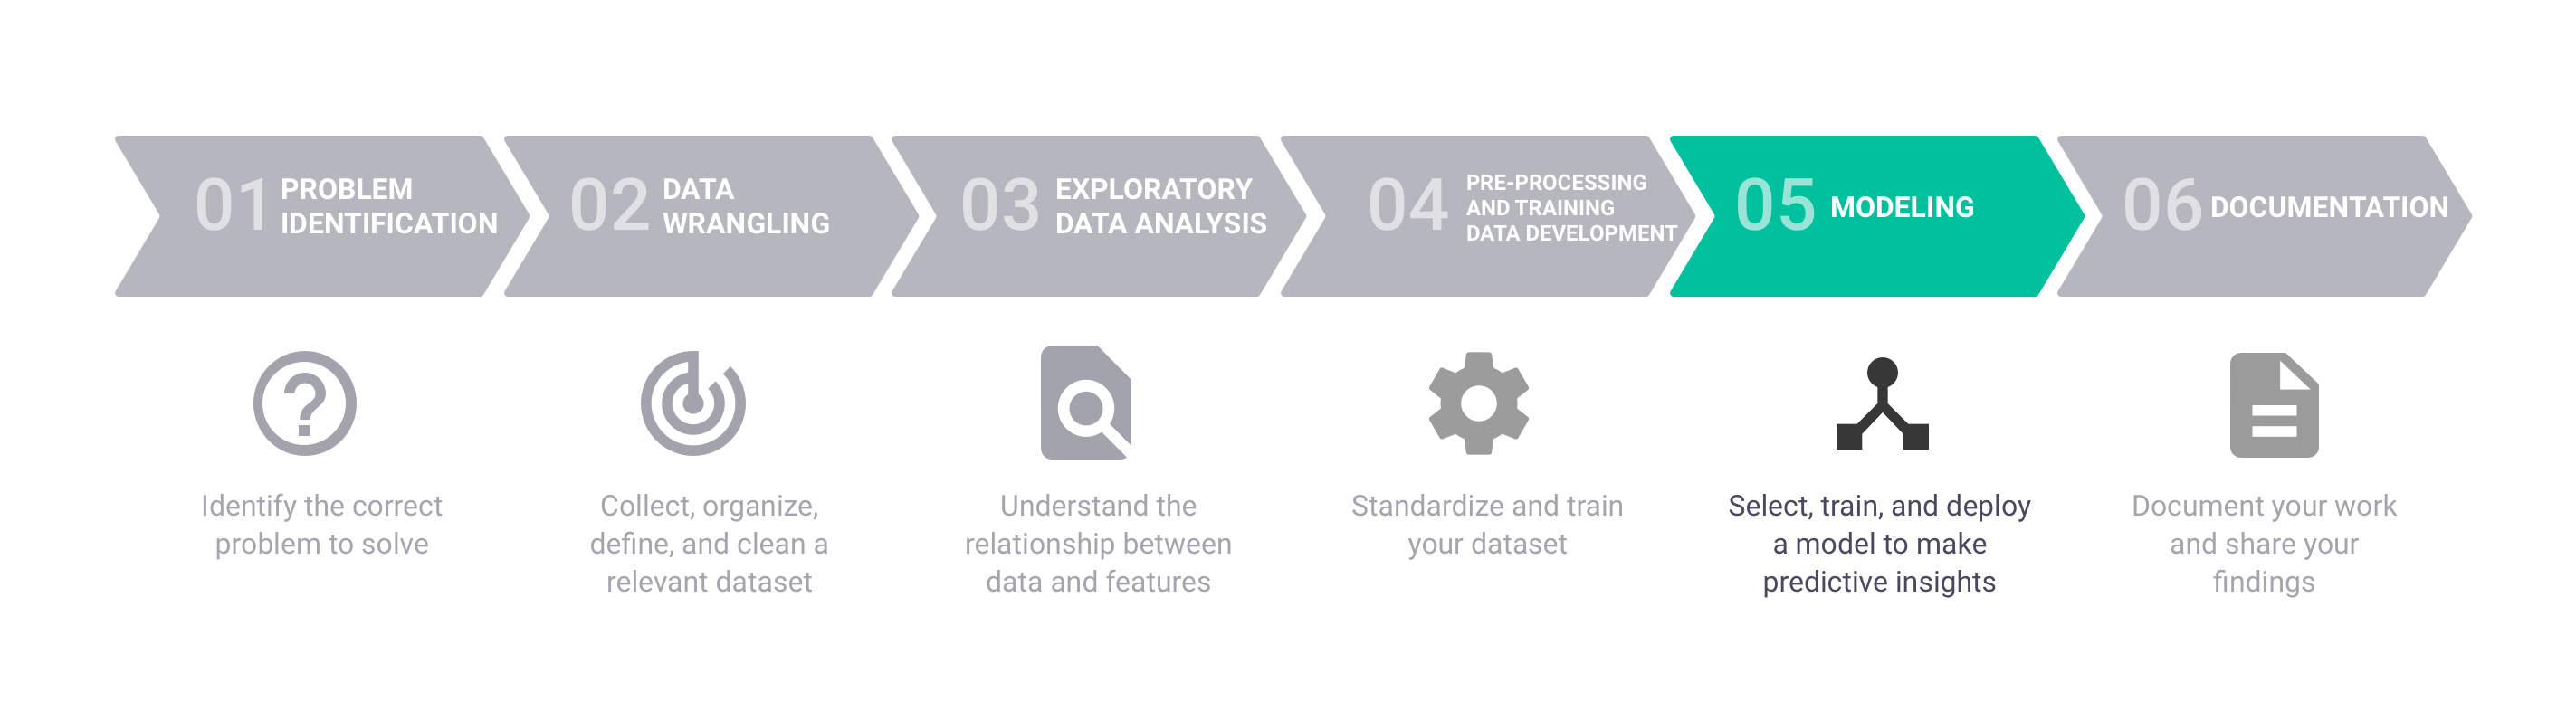

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)
import seaborn as sns
sns.set_theme(style="whitegrid")
from pylab import rcParams

import datetime as dt
from datetime import datetime
import calendar
np.random.seed(123)

import itertools
import math
import missingno as msno


from scipy.signal import argrelextrema
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import lightgbm
from bayes_opt import BayesianOptimization
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


## Final Data Preparation for Time Series Analysis

In [2]:
df = pd.read_csv('../data/interim/state_profit_df.csv', parse_dates = True)

In [3]:
df = df[['Date', 'state_profit']].set_index('Date')
df

,state_profit
Date,
2016-03-24,81.00
2016-03-24,52.08
2016-03-24,159.36
2016-03-17,150.00
2016-03-24,26.52
...,...
2017-11-17,9.63
2018-05-23,17.50
2018-07-26,671.79


In [4]:
df = df.groupby('Date').sum()
df

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-09,312103.77
2012-01-10,300781.67
...,...
2021-06-25,577218.72
2021-06-27,14283.09
2021-06-28,651212.68


One immediate issue we see is that there are some days without data, likely because they made no sales during those days. In order to move on to explore and forecasting, we need to add those dates and have 0 in profit.

In [5]:
whole_data = pd.DataFrame(data = pd.date_range('2012-01-03', end = '2021-06-30'))

In [6]:
whole_data.columns = ['Date']

In [7]:
whole_data['state_profit'] = 0

In [8]:
whole_data

,Date,state_profit
0,2012-01-03,0
1,2012-01-04,0
2,2012-01-05,0
3,2012-01-06,0
4,2012-01-07,0
...,...,...
3462,2021-06-26,0
3463,2021-06-27,0
3464,2021-06-28,0
3465,2021-06-29,0


In [9]:
df.index = pd.to_datetime(df.index)

In [10]:
df_up = df.reset_index()

In [11]:
df_up

,Date,state_profit
0,2012-01-03,338343.67
1,2012-01-04,287668.70
2,2012-01-05,314128.76
3,2012-01-09,312103.77
4,2012-01-10,300781.67
...,...,...
2340,2021-06-25,577218.72
2341,2021-06-27,14283.09
2342,2021-06-28,651212.68
2343,2021-06-29,539286.68


In [12]:
whole_data

,Date,state_profit
0,2012-01-03,0
1,2012-01-04,0
2,2012-01-05,0
3,2012-01-06,0
4,2012-01-07,0
...,...,...
3462,2021-06-26,0
3463,2021-06-27,0
3464,2021-06-28,0
3465,2021-06-29,0


In [13]:
df_up = df_up.merge(whole_data, how = 'right', on = 'Date')

In [14]:
df_up

,Date,state_profit_x,state_profit_y
0,2012-01-03,338343.67,0
1,2012-01-04,287668.70,0
2,2012-01-05,314128.76,0
3,2012-01-06,NaN,0
4,2012-01-07,NaN,0
...,...,...,...
3462,2021-06-26,NaN,0
3463,2021-06-27,14283.09,0
3464,2021-06-28,651212.68,0
3465,2021-06-29,539286.68,0


In [15]:
df_up.state_profit_x = df_up.state_profit_x.fillna(df_up.state_profit_y)
df_up

,Date,state_profit_x,state_profit_y
0,2012-01-03,338343.67,0
1,2012-01-04,287668.70,0
2,2012-01-05,314128.76,0
3,2012-01-06,0.00,0
4,2012-01-07,0.00,0
...,...,...,...
3462,2021-06-26,0.00,0
3463,2021-06-27,14283.09,0
3464,2021-06-28,651212.68,0
3465,2021-06-29,539286.68,0


In [16]:
df = df_up[['Date','state_profit_x']]


In [17]:
df = df.set_index('Date')
df.columns =['state_profit']

In [18]:
df.index = pd.to_datetime(df.index)

In [19]:
df

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-06,0.00
2012-01-07,0.00
...,...
2021-06-26,0.00
2021-06-27,14283.09
2021-06-28,651212.68


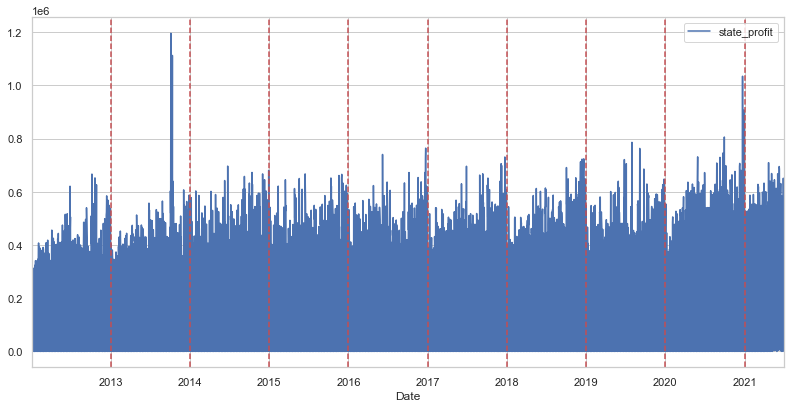

In [20]:
df.plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

> It seems that we have a lot of 0 values, especially from 2012 to the middle of 2016, when this trend started to disapear untilthe middle of 2021 when we start to see again a lot of 0s.

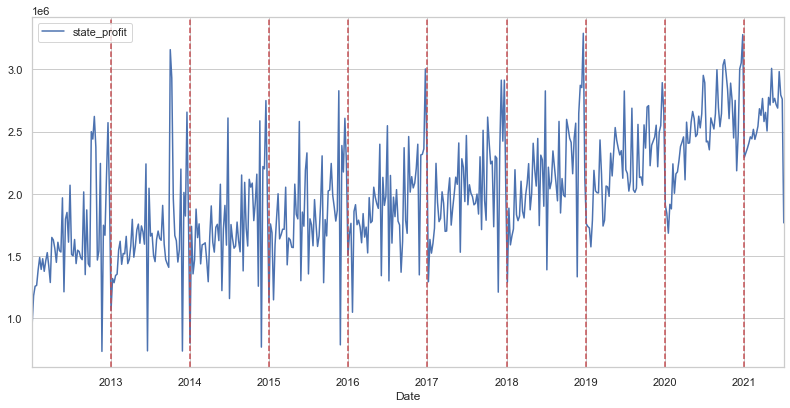

In [21]:
df.resample('W').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

> Looking at the Profit values aggregated per Week, we can see a certain sesonality, with big drops in winter folowed by huge spikes up right before the year end.

> We can also see that there is an apparent increase in the profit over the years, with this growing faster in the past 2 and a half years.


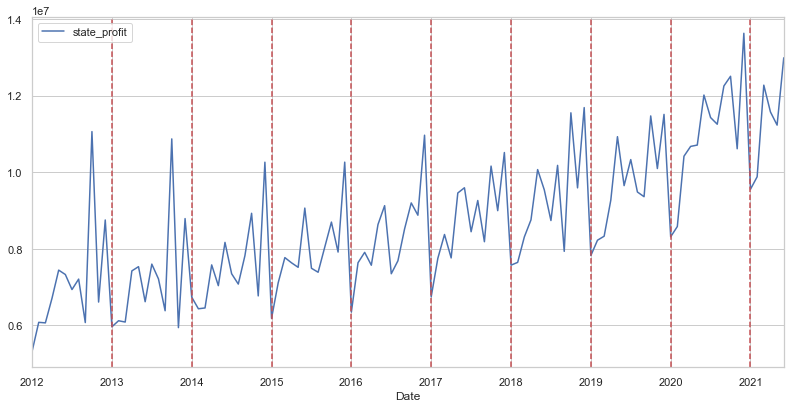

In [22]:
df.resample('M').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

> Aggregated by month, the sesonality is clearer, with a big spike in December. Let's look at the data as well.

In [23]:
df.resample('M').sum().tail(12).T

Date,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30
state_profit,11425543.92,11251787.28,12249942.76,12503554.69,10610884.63,13625794.29,9554119.39,9879334.94,12271348.59,11572070.73,11228231.77,12985685.08


Finnaly, let's look at the data aggregated by Quarted and by year.

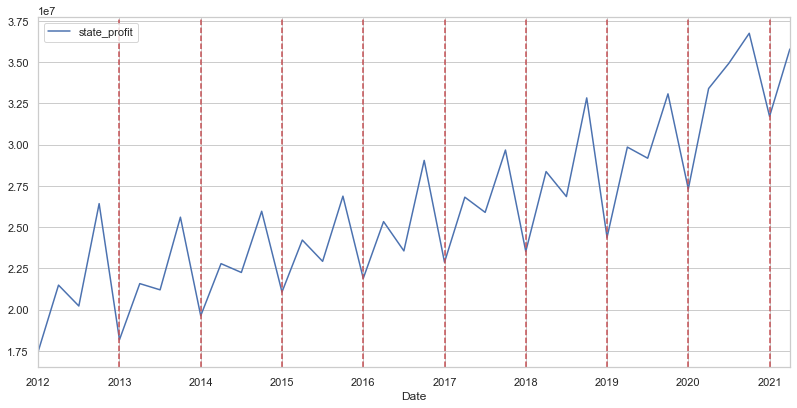

In [24]:
df.resample('Q').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

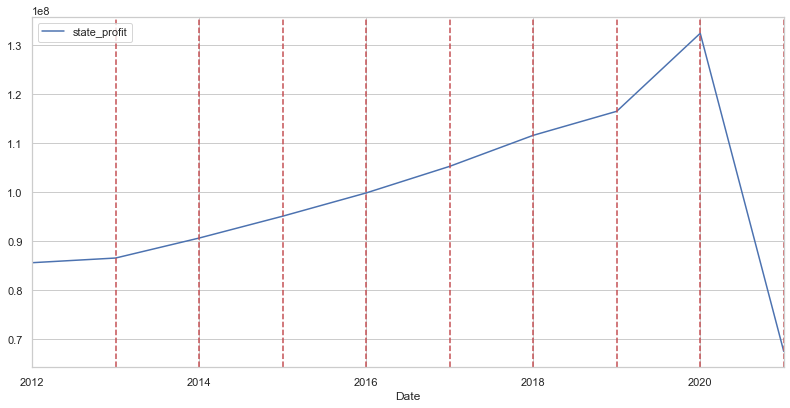

In [25]:
df.resample('Y').sum().plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

We can see that because for 2021 we have onyl the sales until 2021-06-30 we can't see the trend for this last period.

Let's just multiply 2021 with 2 since our data has 6 month of sales and see the trend.

In [26]:
df_yearly = df.resample('Y').sum()
df_yearly

,state_profit
Date,
2012-12-31,8.557850e+07
2013-12-31,8.653254e+07
2014-12-31,9.060711e+07
2015-12-31,9.506513e+07
2016-12-31,9.980815e+07
2017-12-31,1.052320e+08
2018-12-31,1.115549e+08
2019-12-31,1.164576e+08
2020-12-31,1.323686e+08


In [27]:
df_yearly.loc['2021-12-31',:] = df_yearly.loc['2021-12-31',:] *2

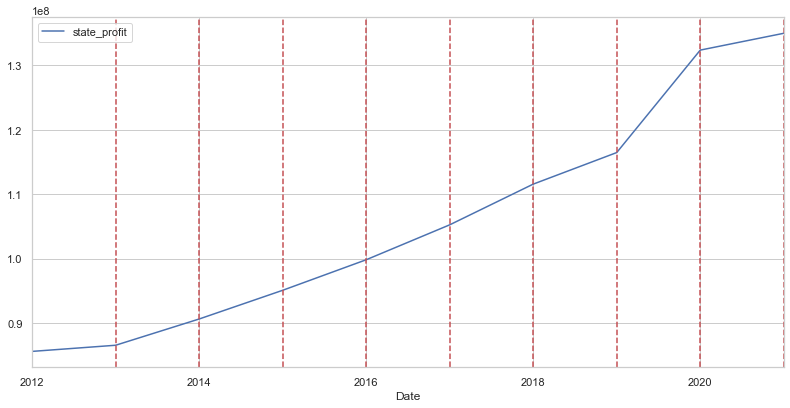

In [28]:
df_yearly.plot()
plt.axvline(x='2013-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2014-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2015-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2016-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2017-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2018-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2019-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2020-01-01',linestyle = '--', color = 'r')
plt.axvline(x='2021-01-01',linestyle = '--', color = 'r')

We can see that the trend is rather constant, apart from 2020, the year of the Pandemic, when the state_profit had increased substantially  more than in the preceding years.

## Profit Analysis by Month and Day of Week

Let's get other date features from our data Field.

In [29]:
df_explore = df
df_explore

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-06,0.00
2012-01-07,0.00
...,...
2021-06-26,0.00
2021-06-27,14283.09
2021-06-28,651212.68


In [30]:
df_explore['year'] = df_explore.index.year
df_explore['month'] = df_explore.index.month
df_explore['day_of_month'] = df_explore.index.day
df_explore['day_of_week'] = df_explore.index.dayofweek
df_explore

,state_profit,year,month,day_of_month,day_of_week
Date,,,,,
2012-01-03,338343.67,2012,1,3,1
2012-01-04,287668.70,2012,1,4,2
2012-01-05,314128.76,2012,1,5,3
2012-01-06,0.00,2012,1,6,4
2012-01-07,0.00,2012,1,7,5
...,...,...,...,...,...
2021-06-26,0.00,2021,6,26,5
2021-06-27,14283.09,2021,6,27,6
2021-06-28,651212.68,2021,6,28,0


We will explore how is the profit ditributed on days of week

In [31]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [32]:
subset = df_explore.groupby(['day_of_week','year'])[['state_profit']].sum()
subset = subset.reset_index()
subset

,day_of_week,year,state_profit
0,0,2012,20431958.13
1,0,2013,22550127.36
2,0,2014,26299267.89
3,0,2015,25930322.07
4,0,2016,24563930.47
...,...,...,...
65,6,2017,0.00
66,6,2018,0.00
67,6,2019,39802.73
68,6,2020,7320.68


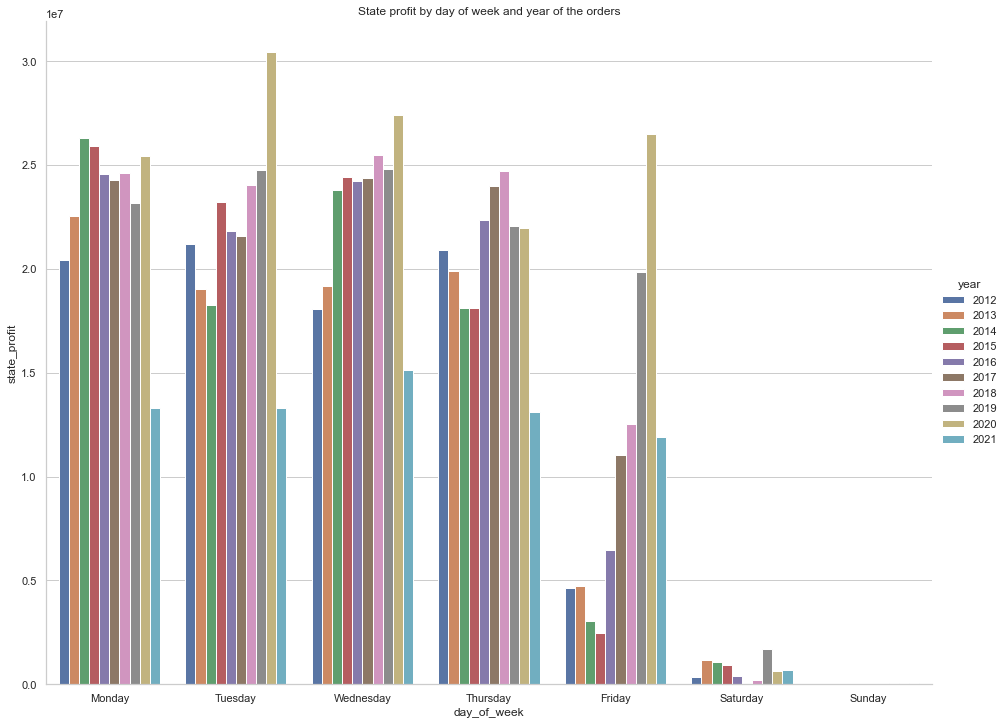

In [33]:
sns.catplot(x="day_of_week", y="state_profit", hue="year",data=subset, kind = 'bar', height = 10, aspect = 1.3)
plt.xticks(range(7), days_order)
plt.title('State profit by day of week and year of the orders')
plt.show()

We can observe that:
1. There are no sales happening on Sunday.
2. There are very few sales on Saturday.
3. If before 2019 there were way fewer Sales(and profit) On Friday orders, since then we can see taht the amount of profit from Friday orders is within the same values as those from any other workday.
4. Sales on Tuesday, Wednesday and Friday were at the highest values in 2020.

In [34]:
subset = df_explore.groupby(['month','year'])[['state_profit']].sum()
subset = subset.reset_index()
subset

,month,year,state_profit
0,1,2012,5320216.31
1,1,2013,5962644.02
2,1,2014,6736369.66
3,1,2015,6181739.35
4,1,2016,6346672.56
...,...,...,...
109,12,2016,10964568.61
110,12,2017,10512415.80
111,12,2018,11685628.39
112,12,2019,11507912.76


Let's see what were the most profitable months

In [35]:
subset.sort_values('state_profit').tail(10)

,month,year,state_profit
112,12,2019,11507912.76
93,10,2018,11549361.31
39,4,2021,11572070.73
111,12,2018,11685628.39
58,6,2020,12013064.33
86,9,2020,12249942.76
29,3,2021,12271348.59
95,10,2020,12503554.69
59,6,2021,12985685.08
113,12,2020,13625794.29


In our top 10 best selling months we have 3 Decembers(2018,2019,2020), 2 Novembers(2018 and 2020), 2 June(2020 and 2021) plus one March(2021), April(2021) and September(2020).

As for the year, we have 2 months in 2018, one in 2019, 4 in 2020 and 3 in 2021.

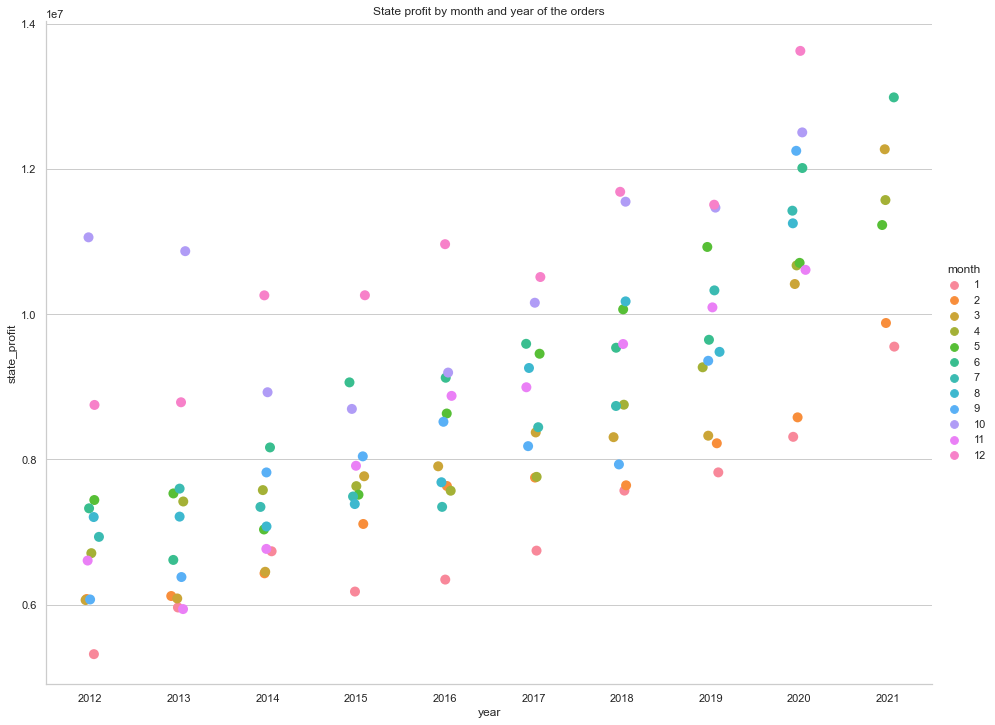

In [36]:
sns.catplot(x="year", y="state_profit", hue="month",data=subset, height = 10, aspect = 1.3, s=10)
plt.title('State profit by month and year of the orders')
plt.show()

## Validation set

So far from the start of the exercise we worked with data from 2012 to June 30th 2021. We recently checked and on Iowa.gov website they recently uploaded another batch of data, containing Sales from **July 2021**.

since this data was not used in any of our analysis, it is the perfect candidate for the **Validation Set**.

Let's load this and clean the data.

In [37]:
validation = pd.read_csv('../data/raw/Iowa_Liquor_Sales July2021.csv', parse_dates = True)
validation.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,INV-37978100001,7/1/2021,3829,Gary's Foods / Mt Vernon,715 1st Ave S,Mount Vernon,52314,NaN,57,LINN,...,5290,J & B Rare Scotch,12,750,12.25,18.38,3,55.14,2.25,0.59
1,INV-37993100030,7/1/2021,5465,Kum & Go #1215 / Ames,4506 Lincoln Way,Ames,50010,NaN,85,STORY,...,36304,Hawkeye Vodka,24,375,1.86,2.79,4,11.16,1.50,0.39
2,INV-37993500004,7/1/2021,4656,Casey's General Store #2301 / Ames,17005 Hwy 69,Ames,50010,NaN,85,STORY,...,43024,Admiral Nelson Spiced,24,375,2.99,4.49,24,107.76,9.00,2.37
3,INV-37973700077,7/1/2021,2538,Hy-Vee Food Store #3 / Waterloo,1422 Flammang Dr,Waterloo,50702,POINT (-92.327917 42.459938),7,BLACK HAWK,...,45248,Paramount Gold Rum,6,1750,7.50,11.25,6,67.50,10.50,2.77
4,INV-37969700044,7/1/2021,5314,Tobacco Hut & Liquor,3134 Manawa Center Dr. # 9,Council Bluffs,51501,POINT (-95.847514 41.228712),78,POTTAWATTA,...,35926,Five O'Clock Vodka PET,12,750,3.37,5.06,6,30.36,4.50,1.18


In [38]:
validation['state_profit'] =  (validation['State Bottle Retail'] - validation['State Bottle Cost']) * validation['Bottles Sold']

In [39]:
validation.head().T

,0,1,2,3,4
Invoice/Item Number,INV-37978100001,INV-37993100030,INV-37993500004,INV-37973700077,INV-37969700044
Date,7/1/2021,7/1/2021,7/1/2021,7/1/2021,7/1/2021
Store Number,3829,5465,4656,2538,5314
Store Name,Gary's Foods / Mt Vernon,Kum & Go #1215 / Ames,Casey's General Store #2301 / Ames,Hy-Vee Food Store #3 / Waterloo,Tobacco Hut & Liquor
Address,715 1st Ave S,4506 Lincoln Way,17005 Hwy 69,1422 Flammang Dr,3134 Manawa Center Dr. # 9
City,Mount Vernon,Ames,Ames,Waterloo,Council Bluffs
Zip Code,52314,50010,50010,50702,51501
Store Location,NaN,NaN,NaN,POINT (-92.327917 42.459938),POINT (-95.847514 41.228712)
County Number,57,85,85,7,78
County,LINN,STORY,STORY,BLACK HAWK,POTTAWATTA


In [40]:
validation = validation.groupby('Date')[['state_profit']].sum()
validation               

,state_profit
Date,
7/1/2021,523871.28
7/11/2021,4483.79
7/12/2021,440662.66
7/13/2021,497241.58
7/14/2021,648845.53
7/15/2021,467958.67
7/16/2021,427222.59
7/18/2021,2765.07
7/19/2021,421307.16


In [41]:
missing_dates = pd.DataFrame(data = pd.date_range('2021-07-01', end = '2021-07-31'))

In [42]:
missing_dates['state_profit'] = 0
missing_dates.head()

,0,state_profit
0,2021-07-01,0
1,2021-07-02,0
2,2021-07-03,0
3,2021-07-04,0
4,2021-07-05,0


In [43]:
missing_dates.columns = ['Date', 'state_profit']

In [44]:
validation.index = pd.to_datetime(validation.index)

In [45]:
validation = validation.reset_index()

In [46]:
validation = validation.merge(missing_dates, how = 'right', on = 'Date')
validation['state_profit_x'] = validation.state_profit_x.fillna(validation.state_profit_y)
validation

,Date,state_profit_x,state_profit_y
0,2021-07-01,523871.28,0
1,2021-07-02,544700.35,0
2,2021-07-03,0.00,0
3,2021-07-04,2947.96,0
4,2021-07-05,597425.16,0
5,2021-07-06,451192.81,0
6,2021-07-07,765833.39,0
7,2021-07-08,666462.03,0
8,2021-07-09,457611.57,0
9,2021-07-10,0.00,0


In [47]:
y_true = validation[['Date','state_profit_x']]

y_true = y_true.set_index('Date')
y_true.index = pd.to_datetime(y_true.index)
y_true.head()

,state_profit_x
Date,
2021-07-01,523871.28
2021-07-02,544700.35
2021-07-03,0.00
2021-07-04,2947.96
2021-07-05,597425.16


In [48]:
y_true.columns = ['state_profit']

In [49]:
y_true.head()

,state_profit
Date,
2021-07-01,523871.28
2021-07-02,544700.35
2021-07-03,0.00
2021-07-04,2947.96
2021-07-05,597425.16


## Analyzing Trend, Seasonality and White Noise(Residuals)

### Monthly Time-Series Decomposition

In [50]:
df = df.drop(['year','month','day_of_month','day_of_week'], axis = 1)
df

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-06,0.00
2012-01-07,0.00
...,...
2021-06-26,0.00
2021-06-27,14283.09
2021-06-28,651212.68


In [51]:
df_m = df.resample('M').sum()

df_m.reset_index(inplace=True)
df_m['Date'] = pd.to_datetime(df_m['Date'])
df_m = df_m.set_index('Date')
    
df_m

,state_profit
Date,
2012-01-31,5320216.31
2012-02-29,6079004.91
2012-03-31,6064927.47
2012-04-30,6710304.28
2012-05-31,7442166.62
...,...
2021-02-28,9879334.94
2021-03-31,12271348.59
2021-04-30,11572070.73


In [52]:
def decompose(data):
    
    s=seasonal_decompose(data)
    rcParams['figure.figsize'] = 15, 12
    s.plot()
    pass
    return s

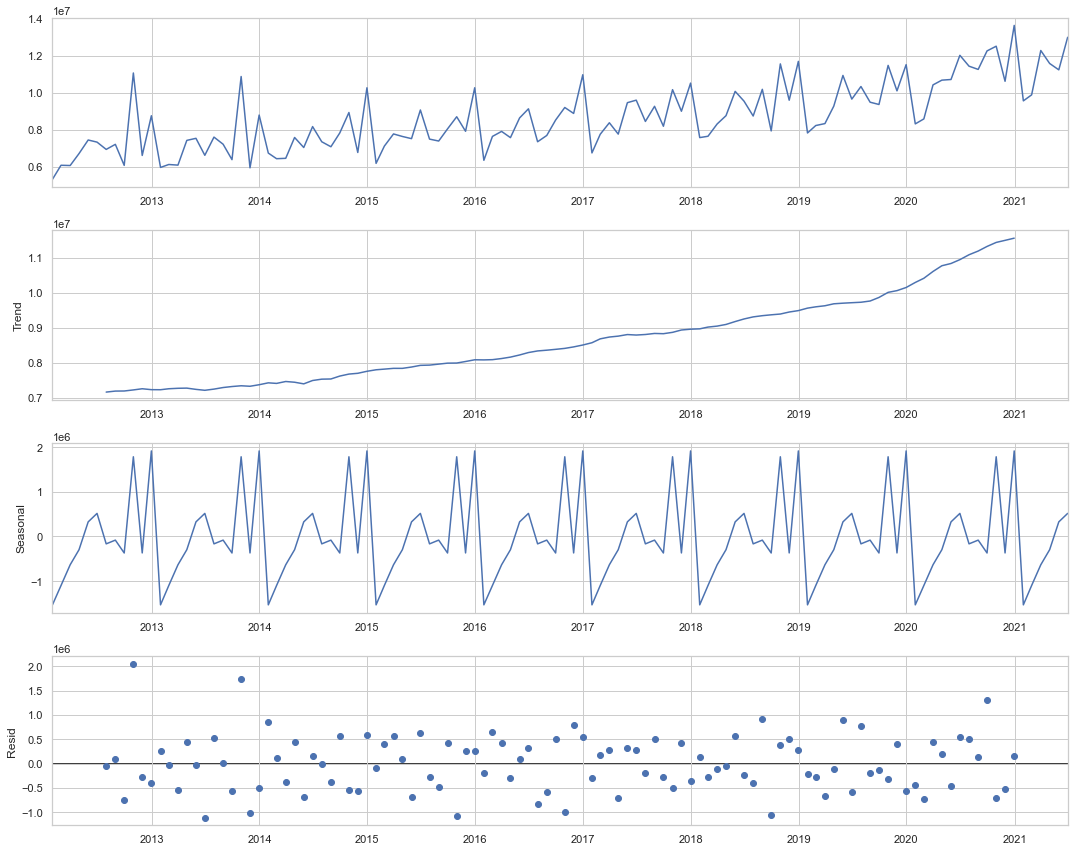

In [53]:
m = decompose(df_m)

We can see in the monthly Profit Decomposition that the **Trend** is definitely an increasing one, with a higher increase in 2020.

There is a fairly evident **Monthly Seasonality**:
- January has the least profits, but these increase until the Summer month, July and August.
- Towards the eand of the year we have the months with the biggest Sales and Profits: October and Dcember.

The residuals are the values that remain after we deducted the general Trend and Monthly Seasonality.
We can see that generally the residuals are quite low, most of them ranging between -1e6 and 1e6. Considering the ranges of the Trend and Seasonality, we can say that our Profits have a defined clear Monthly Seasonality.

### Weekly Decomposition

Since we have this high Monthly Seasonality let's check if the Weekly Seasonality is as well clearly defined.

In [54]:
df_w = df.resample('W').sum()

df_w.reset_index(inplace=True)
df_w['Date'] = pd.to_datetime(df_w['Date'])
df_w = df_w.set_index('Date')

df_w

,state_profit
Date,
2012-01-08,940141.13
2012-01-15,1181255.09
2012-01-22,1257495.11
2012-01-29,1263748.29
2012-02-05,1389383.64
...,...
2021-06-06,2688185.42
2021-06-13,2981229.17
2021-06-20,2793652.76


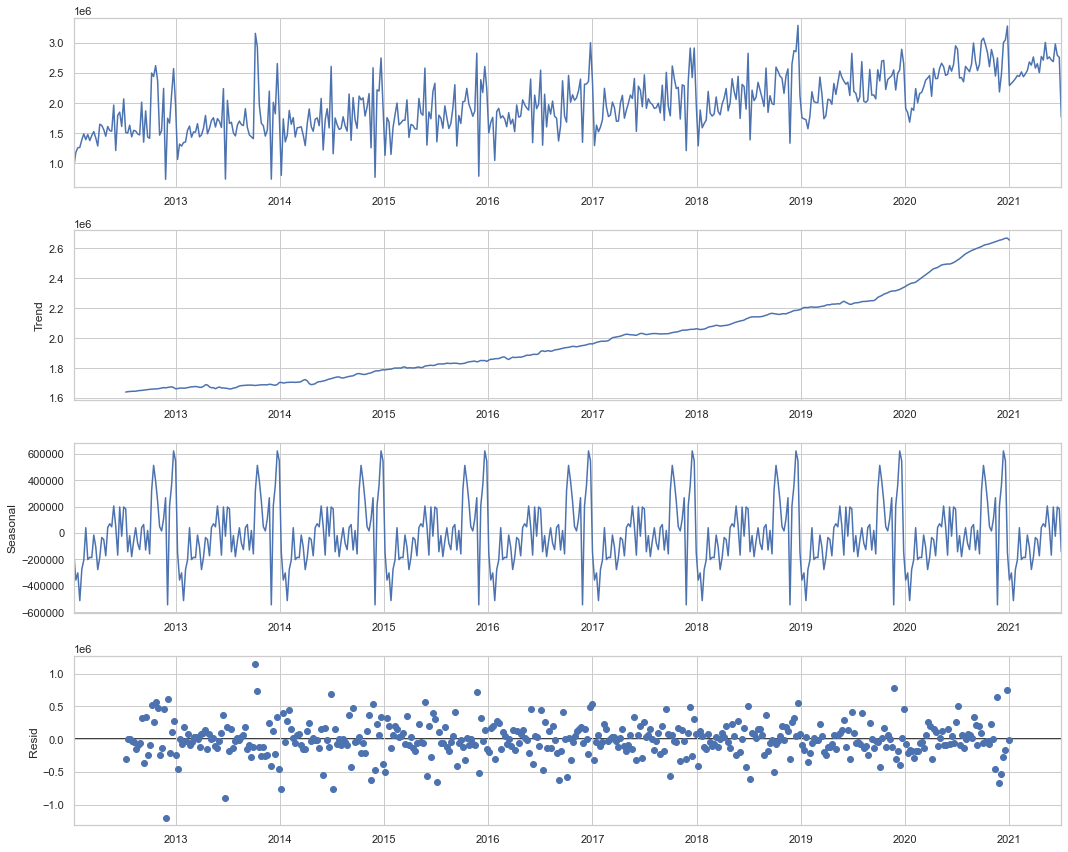

In [55]:
w = decompose(df_w)

We can observe that with the Weekly seasonality, the values of the residuals are often even higher than the ranges of the Seasonality. This means the seasonality variations are not as consistent as those of the weekly aggregates.

Text(0.5, 1.0, 'Monthly and weekly profit Aggregations Seasonality')

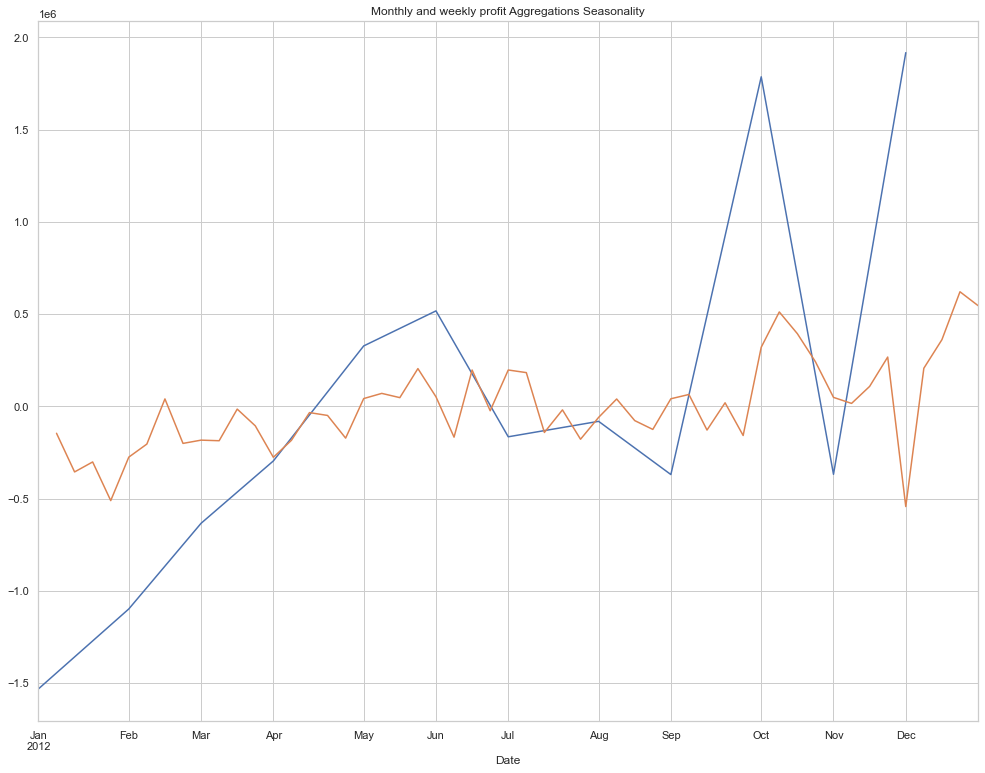

In [56]:
m.seasonal['2012'].plot()
w.seasonal['2012'].plot()
plt.title('Monthly and weekly profit Aggregations Seasonality')

### Quarterly Decomposition

In [57]:
df_q = df.resample('Q').sum()

df_q.reset_index(inplace=True)
df_q['Date'] = pd.to_datetime(df_q['Date'])
df_q = df_q.set_index('Date')

df_q.head()

,state_profit
Date,
2012-03-31,17464148.69
2012-06-30,21480255.66
2012-09-30,20215281.07
2012-12-31,26418809.83
2013-03-31,18169577.47


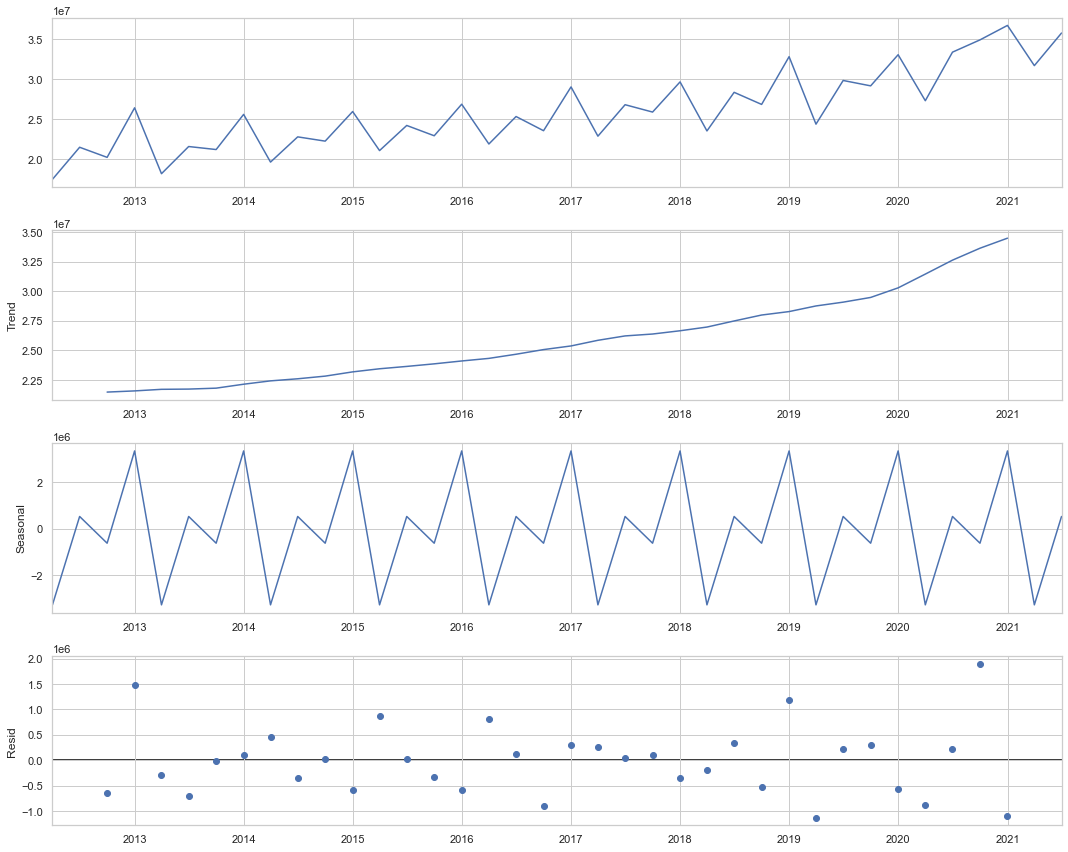

In [58]:
q = decompose(df_q)

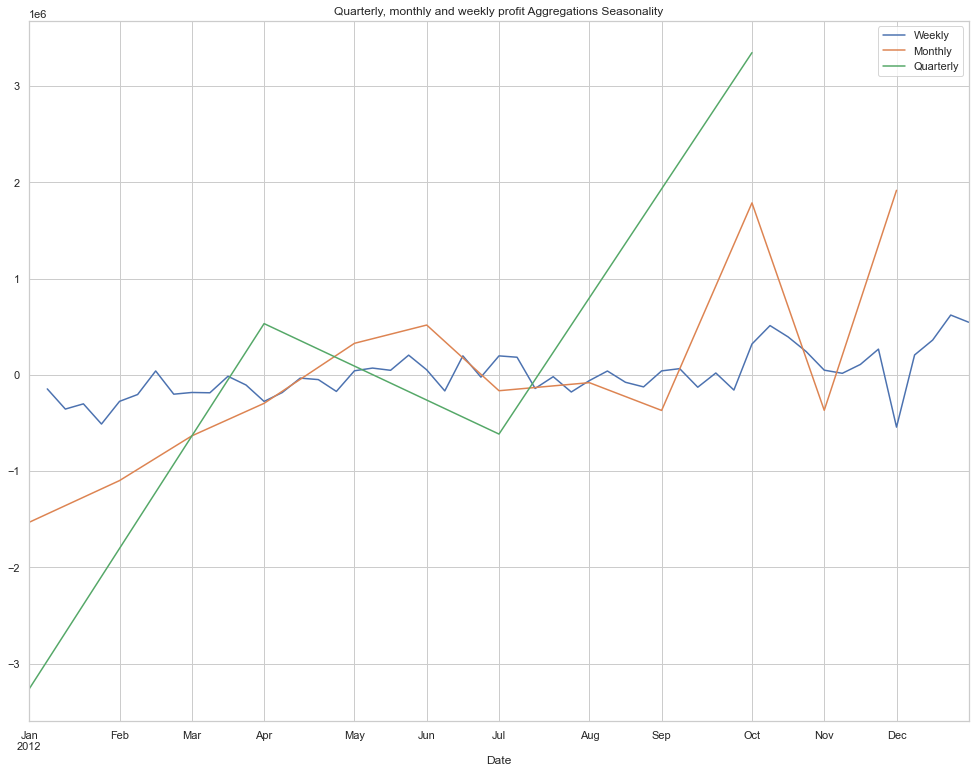

In [59]:
w.seasonal['2012'].plot(label = 'Weekly')
m.seasonal['2012'].plot(label = 'Monthly')
q.seasonal['2012'].plot(label = 'Quarterly')
plt.title('Quarterly, monthly and weekly profit Aggregations Seasonality')
plt.legend()

## Stationary Time Series and Forecasting

These are a few notions about stationarity and non-stationarity from [MachineLearningMastery.com](https://machinelearningmastery.com/time-series-data-stationary-python)

>The notion of stationarity comes from the theoretical study of time series and it is a useful abstraction when forecasting.<br>The observations in a stationary time series are not dependent on time.
<br>Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
<br>Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time index.
<br>Summary statistics like the mean and variance do change over time, providing a drift in the concepts a model may try to capture.

> Should you make your time series stationary?
<br>
Generally, yes.
<br>
If you have clear trend and seasonality in your time series, then model these components, remove them from observations, then train models on the residuals.
<br>
But…
<br>
We turn to machine learning methods when the classical methods fail. When we want more or better results. We cannot know how to best model unknown nonlinear relationships in time series data and some methods may result in better performance when working with non-stationary observations or some mixture of stationary and non-stationary views of the problem.
<br>
The suggestion here is to treat properties of a time series being stationary or not as another source of information that can be used in feature engineering and feature selection on your time series problem when using machine learning methods.

It is abvious that for our industry there were some clear shifts in the amount of Sales and profits since the start of the pandemic.
Since in August 2021, our current month, we are still not out of this situation, and there are posibilities of other new waves emerging and new restrictions imposing, we **will not make our data stationary for further predictions** because we consider ourself in an emerging market.

Another reason for that is that the ARIMA, SARIMA and SARIMAX models all work on non-stationary data.

Nonetheless, let's explore the Autocorrelations of our data on different levels of Aggregations and then let's **explore if our Daily aggregated Profits are Stationary data using Hypothesis Testing and the augmented Dickey-Fuller test**.

### Autocorrelations on different level of Aggregation

First we will have to calculate the percentage change of the values.

In [60]:
df.head()

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-06,0.00
2012-01-07,0.00


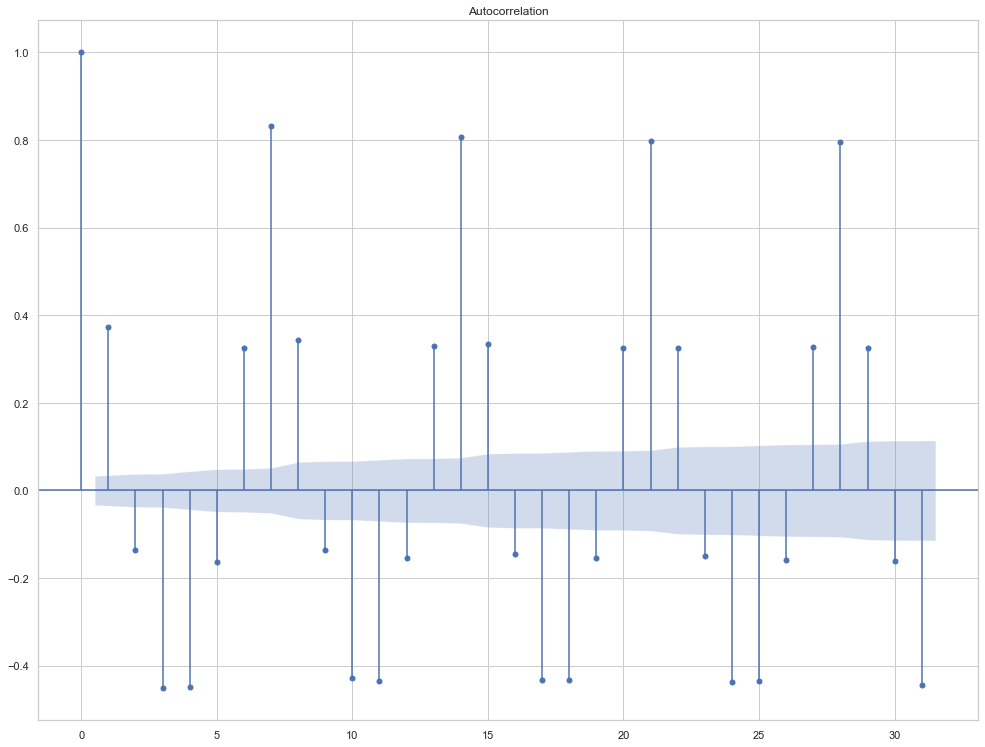

In [61]:
plot_acf(df['state_profit'], lags = 31, alpha = 0.05);

In [62]:
df_explore = df.copy()
df_explore['diff'] = df_explore['state_profit'].diff()
df_explore = df_explore.dropna()
df_explore

,state_profit,diff
Date,,
2012-01-04,287668.70,-50674.97
2012-01-05,314128.76,26460.06
2012-01-06,0.00,-314128.76
2012-01-07,0.00,0.00
2012-01-08,0.00,0.00
...,...,...
2021-06-26,0.00,-577218.72
2021-06-27,14283.09,14283.09
2021-06-28,651212.68,636929.59


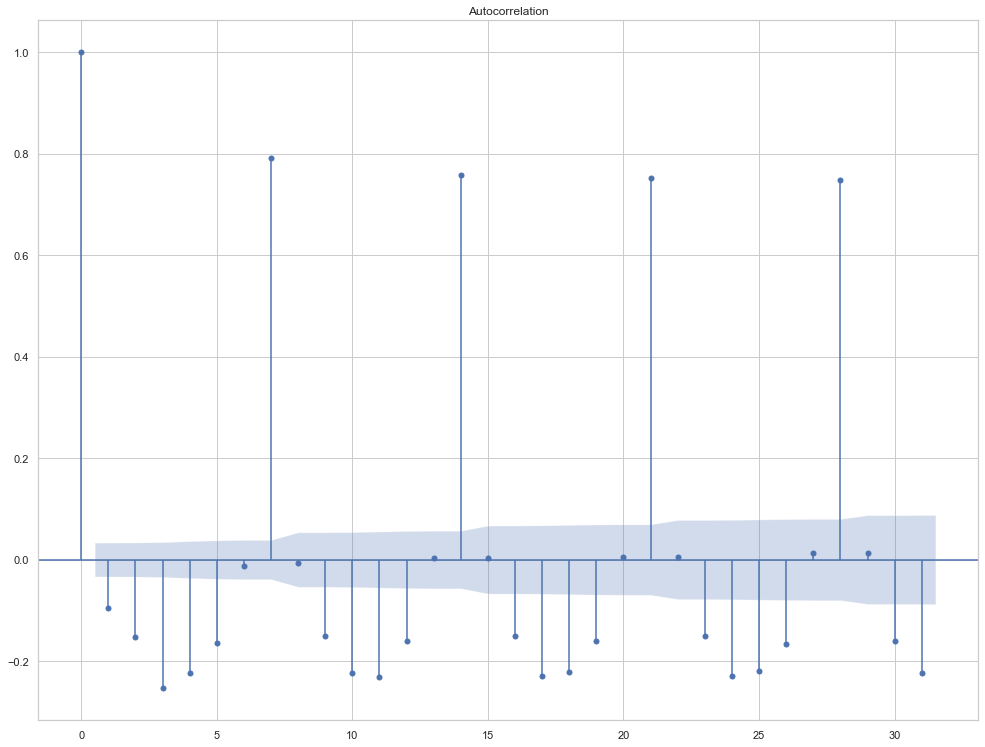

In [63]:
plot_acf(df_explore['diff'], lags = 31, alpha = 0.05);

Let's try with diff 7

In [64]:
df_explore['diff7'] = df_explore['state_profit'].diff(7)
df_explore = df_explore.dropna()
df_explore

,state_profit,diff,diff7
Date,,,
2012-01-11,258539.75,-42241.92,-29128.95
2012-01-12,309829.90,51290.15,-4298.86
2012-01-13,0.00,-309829.90,0.00
2012-01-14,0.00,0.00,0.00
2012-01-15,0.00,0.00,0.00
...,...,...,...
2021-06-26,0.00,-577218.72,0.00
2021-06-27,14283.09,14283.09,2227.53
2021-06-28,651212.68,636929.59,66957.20


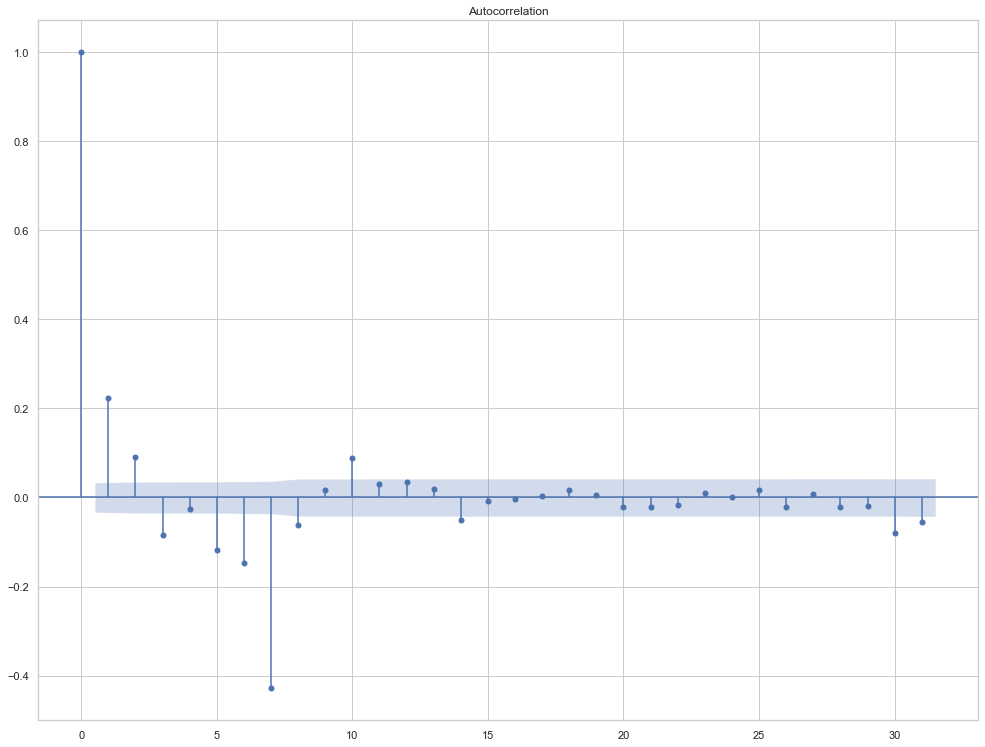

In [65]:
plot_acf(df_explore['diff7'], lags = 31, alpha = 0.05);

If we plot the daily autocorrelation we can see that we high correlations, especially on the 7th records( weekly seasonality).

### Weekly autocorrelations

In [66]:
w = df.resample('W').sum()

w['pct_change'] = w['state_profit'].pct_change()
w = w.dropna()
w

,state_profit,pct_change
Date,,
2012-01-15,1181255.09,0.256466
2012-01-22,1257495.11,0.064542
2012-01-29,1263748.29,0.004973
2012-02-05,1389383.64,0.099415
2012-02-12,1488214.15,0.071133
...,...,...
2021-06-06,2688185.42,-0.010137
2021-06-13,2981229.17,0.109012
2021-06-20,2793652.76,-0.062919


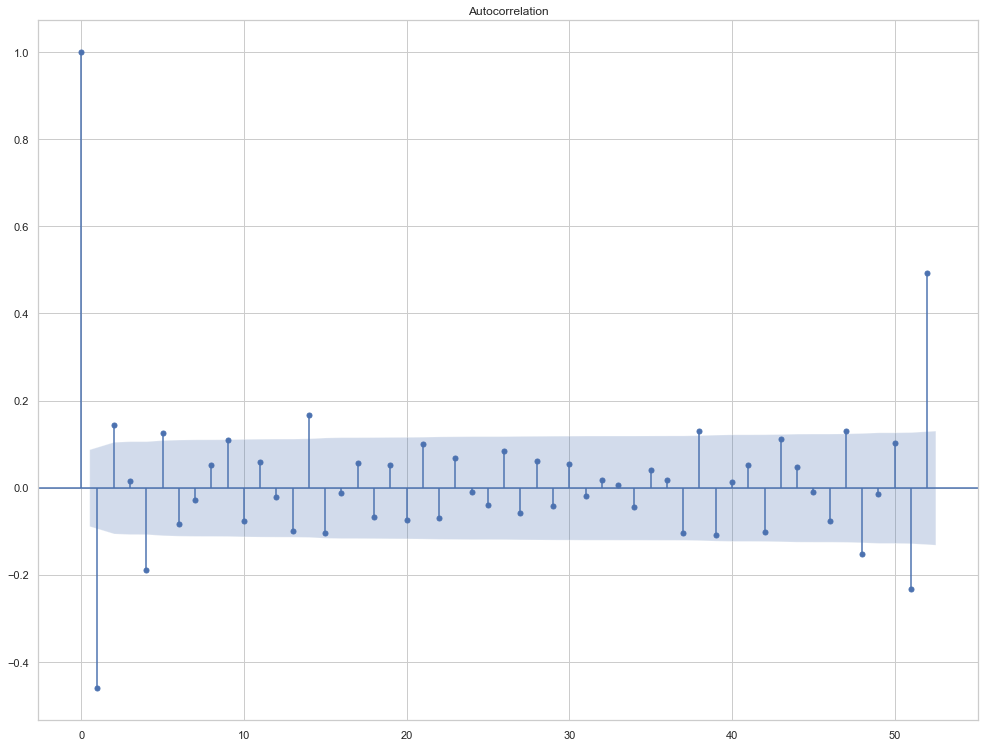

In [67]:
plot_acf(w['pct_change'], lags = 52, alpha = 0.05);

We can see a positive autocorrelation on the 52nd record, that means there is a yearly seasonality.

Also we see a negative autocorrelationon week 1, whick means that after a week had some nice profits, ussualy it comes one without. And the other way around.

That is exactly the statistical priciple of **Regression to the mean** that explains why different natural processes have the tendancy to regress to their mean after an extreme value.

### Monthly autocorrelations

In [68]:
m = df.resample('M').sum()

m['pct_change'] = m['state_profit'].pct_change()
m = m.dropna()
m

,state_profit,pct_change
Date,,
2012-02-29,6079004.91,0.142624
2012-03-31,6064927.47,-0.002316
2012-04-30,6710304.28,0.106411
2012-05-31,7442166.62,0.109065
2012-06-30,7327784.76,-0.015369
...,...,...
2021-02-28,9879334.94,0.034039
2021-03-31,12271348.59,0.242123
2021-04-30,11572070.73,-0.056985


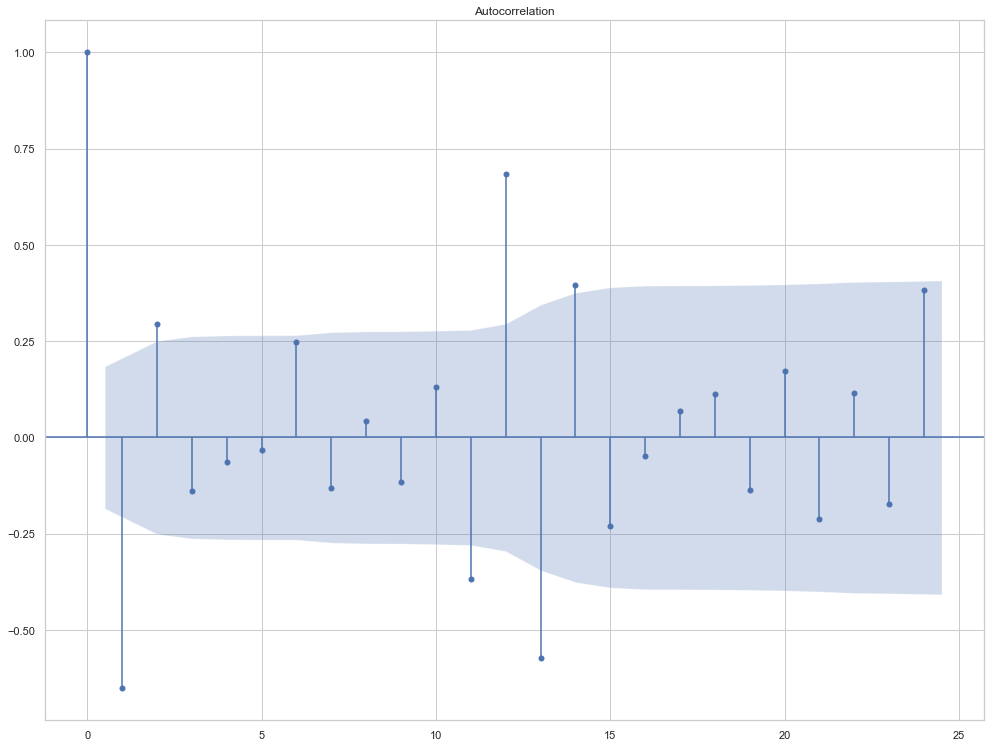

In [69]:
plot_acf(m['pct_change'], lags = 24, alpha = 0.05);

The monthly aggregated data is, as expected, a bit more autocorrelated. Especially a high positive correlation on the 12th period. Again, this is as expected.

the other high autocorrelation is the negative autocorrelation with the 1st period. It is the same situation as with the Weekly aggregations: after a month that had high profits ussualy comes a month without as much.

### Quarterly autocorrelations

In [70]:
q = df.resample('q').sum()

q['pct_change'] = q['state_profit'].pct_change()
q = q.dropna()
q.head()

,state_profit,pct_change
Date,,
2012-06-30,21480255.66,0.229963
2012-09-30,20215281.07,-0.058890
2012-12-31,26418809.83,0.306873
2013-03-31,18169577.47,-0.312248
2013-06-30,21571853.74,0.187251


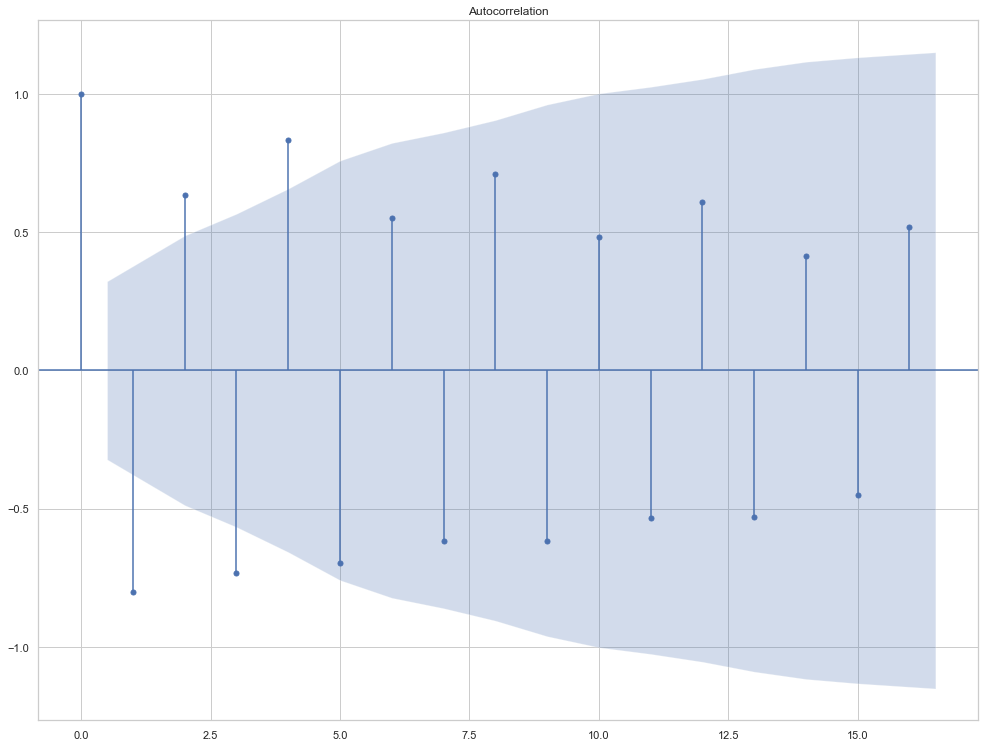

In [71]:
plot_acf(q['pct_change'], alpha = 0.05);

We can see that the **negative autocorrelation** is clearly visible when **Profit is aggregated on Quarters**.

## Unit Root Test - Hypothesis Testing

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [72]:
df

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-06,0.00
2012-01-07,0.00
...,...
2021-06-26,0.00
2021-06-27,14283.09
2021-06-28,651212.68


In [73]:
def adf_test(timeseries):  
    '''Perform Dicky-Fuller test'''
    print('\nResults of Dickey-Fuller Test:')
        
    # Set autolag as BIC, so the number of lags is chosen to minimize the corresponding information criterion
    df_test = adfuller(timeseries, autolag= 'BIC') 


    df_output = pd.Series(df_test[0:4] , index= ['test statistic', 'p-value', '# Lags Used','# Observation Used'])
    for key, value in df_test[4].items():
        df_output['Critical Value {}'.format(key)] = value
    print(df_output)

In [74]:
adf_test(df['state_profit'])


Results of Dickey-Fuller Test:
test statistic          -5.173170
p-value                  0.000010
# Lags Used             29.000000
# Observation Used    3437.000000
Critical Value 1%       -3.432254
Critical Value 5%       -2.862381
Critical Value 10%      -2.567218
dtype: float64


Running the test gives us the **test statistic value of -5.17**. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset).

As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -5.17 is less than the value of -3.43 at 1%.

This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

## Model Evaluation

**Scaled Errors**. The forecast error, E, is on the same scale as the data, as such, these accuracy measures are scale-dependent and cannot be used to make comparisons between series on different scales.

The mean absolute error, or **MAE**, is calculated as the average of the forecast error values, where all of the forecast error values are forced to be positive.

The mean squared error, or **MSE**, is calculated as the average of the squared forecast error values. Squaring the forecast error values forces them to be positive; it also has the effect of putting more weight on large errors.

The mean squared error described above is in the squared units of the predictions. It can be transformed back into the original units of the predictions by taking the square root of the mean squared error score. This is called the root mean squared error, or **RMSE**.

**Percentage Errors**. These are more frequently used to compare forecast performance between different data sets because they are scale-independent. However, they have the disadvantage of being infinite or undefined if Y is close to or equal to zero.

Mean absolute percentage error (**MAPE**) or mean absolute percentage deviation (MAPD). 

To compare the optimal models, the following measurements are calculated for each one:
* **root-mean-square error (RMSE)**
* **mean absolute error(MAE)**
* **mean absolute percentage error(MAPE)**

But we will choose our optimal model with the smallest RMSE.

We will create our results DataFrame:

In [86]:
results = pd.DataFrame(columns = ['data_agg', 'model','params','rmse', 'mae'])
pd.set_option("max_colwidth", 100)

In [87]:
def save_scores(model, data_agg, model_name, parameters):
    
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),2)
    mae = round(mean_absolute_error(y_true, y_pred),2)
    
    new_row = {'data_agg': data_agg,
               'model':model_name,
               'params':parameters,
               'rmse': rmse,
               'mae': mae}
    results.loc[0 if pd.isnull(results.index.max()) else results.index.max() + 1] = new_row

# Modeling

We will conduct our modeling on 2 different aggregation types. 

We will use different variation of Autoregression, Moving Average, ARMA, ARIMA and SARIMAX models on our daily aggregated data, and then on the same data aggregated by month.

## On Daily Data

First we will do our modeling with our daily Aggregations data.The advantage with that is what as our Hypethesis testing showed, it is a stationary data.

Before that we have to decide on what data to use to make our predictions. We will use data since 01-01-2019. This way we will account for the seasonality and trends from both 2019 and 2020.

First let's find out how many records we will use by finding the index of 01-01-2019.

In [88]:
index_s = df.reset_index()
index_s[index_s['Date'] >= '2019-01-01']

,Date,state_profit
2555,2019-01-01,0.00
2556,2019-01-02,357453.40
2557,2019-01-03,389278.46
2558,2019-01-04,460306.08
2559,2019-01-05,0.00
...,...,...
3462,2021-06-26,0.00
3463,2021-06-27,14283.09
3464,2021-06-28,651212.68
3465,2021-06-29,539286.68


So we have a total of 912 records from 2019 until current. And the index start is **2555**. The current index is at **3466**. So if we want to predict for the next month, July, we will have to go to **3497**.

In [89]:
df_daily = df[['state_profit']]
df_daily

,state_profit
Date,
2012-01-03,338343.67
2012-01-04,287668.70
2012-01-05,314128.76
2012-01-06,0.00
2012-01-07,0.00
...,...
2021-06-26,0.00
2021-06-27,14283.09
2021-06-28,651212.68


## Autoregressive (AR) model

The method models the next step in the sequence as a linear function of the observations at prior time steps.

Parameter of the model:

Number of AR terms(p) is the number of lags of dependent variable(past values). For instance if p is 3, the predictors for x(3) are x(1) and x(2).

The trend to include in the model:

### AR(1)

In [90]:
model = ARMA(df_daily, order = (1,0))
model_fit = model.fit()

In [91]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           state_profit   No. Observations:                 3467
Model:                     ARMA(1, 0)   Log Likelihood              -47488.542
Method:                       css-mle   S.D. of innovations         214988.687
Date:                Fri, 13 Aug 2021   AIC                          94983.083
Time:                        16:41:58   BIC                          95001.536
Sample:                    01-03-2012   HQIC                         94989.672
                         - 06-30-2021                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2.858e+05   5815.370     49.137      0.000    2.74e+05    2.97e+05
ar.L1.state_profit     0.3722      0.016     23.615      0.000       0.341       0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6864           +0.0000j            2.6864            0.0000
-----------------------------------------------------------------------------
"""

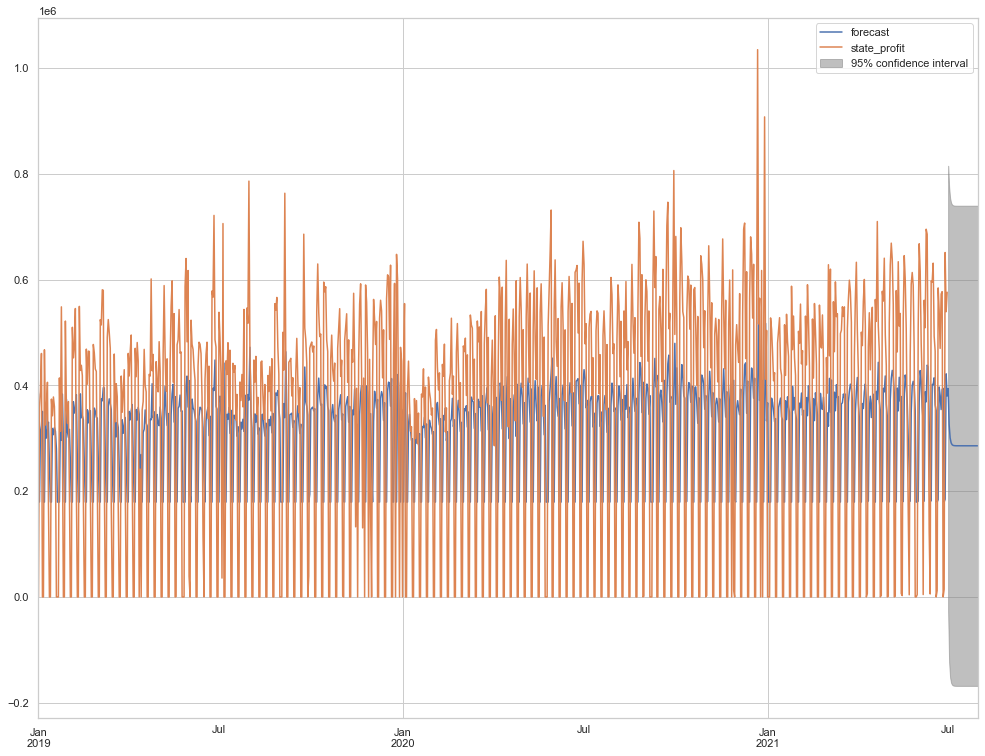

In [92]:
model_fit.plot_predict(start = 2555 , end = 3497);

Creating the y_pred

In [93]:
y_pred = model_fit.forecast(steps = 31)[0]

In [94]:
y_pred

array([393843.03487173, 325987.5917544 , 300728.43535003, 291325.7264007 ,
       287825.57246957, 286522.64183462, 286037.62652589, 285857.07980806,
       285789.87137828, 285764.85307228, 285755.54001978, 285752.07324042,
       285750.78273346, 285750.30234285, 285750.12351768, 285750.05695009,
       285750.03217034, 285750.02294609, 285750.01951237, 285750.01823416,
       285750.01775835, 285750.01758123, 285750.0175153 , 285750.01749076,
       285750.01748162, 285750.01747822, 285750.01747696, 285750.01747648,
       285750.01747631, 285750.01747624, 285750.01747622])

In [95]:
y_true.values

array([[523871.28      ],
       [544700.35      ],
       [     0.        ],
       [  2947.96      ],
       [597425.16      ],
       [451192.81      ],
       [765833.39000001],
       [666462.03000001],
       [457611.57      ],
       [     0.        ],
       [  4483.79      ],
       [440662.66      ],
       [497241.58      ],
       [648845.53      ],
       [467958.67      ],
       [427222.59      ],
       [     0.        ],
       [  2765.07      ],
       [421307.16      ],
       [611883.15      ],
       [691006.28      ],
       [501054.41      ],
       [483071.22      ],
       [     0.        ],
       [  1363.88      ],
       [491530.        ],
       [475522.        ],
       [532262.18      ],
       [444925.64      ],
       [571680.        ],
       [     0.        ]])

In [96]:
save_scores(model_fit, 'daily_agg', 'Auto_regressive', 'p = 1')

In [97]:
results

,data_agg,model,params,rmse,mae
0,daily_agg,Auto_regressive,p = 1,266812.03,253416.67


## Information Criteria

It adjusts goodness-of-fit for number of parameters

Two popular adjusted goodness-of-fit measures:
* AIC( Akaike Information Criterion)
* BIC(Bayesian Information Criterion)

The BIC values have to be minimized to increase accuracy of predictions, but if we are using too many terms with our AR model this will become overfitting.

An important aspect when choosing the BIC is to make sure we take into accounts the data seasonality, therefore we want to make sure BIC range is over 7. In our case we will go to BIC = 25.

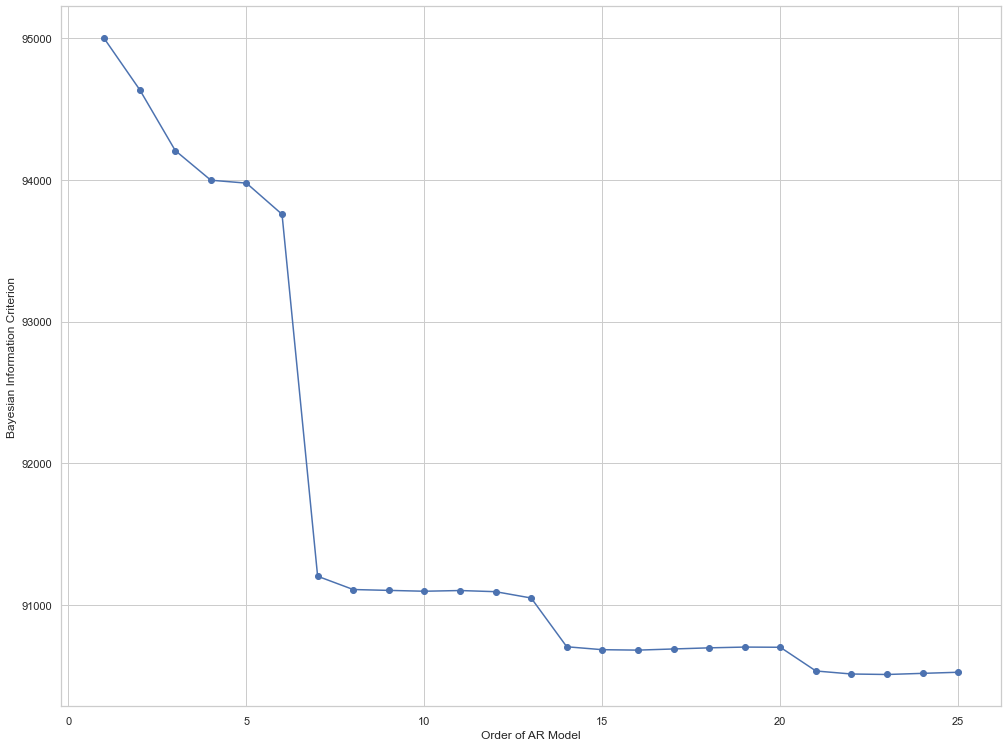

In [98]:

BIC = np.zeros(26)
for p in range(26):
    mod = ARMA(df_daily, order=(p,0))
    model_fit = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = model_fit.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,26), BIC[1:26], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

### AR22

We see that the **minimum BIC is at AR of order 22.**

In [99]:
model22 = ARMA(df_daily, order=(22,0))
model_fit = model22.fit()

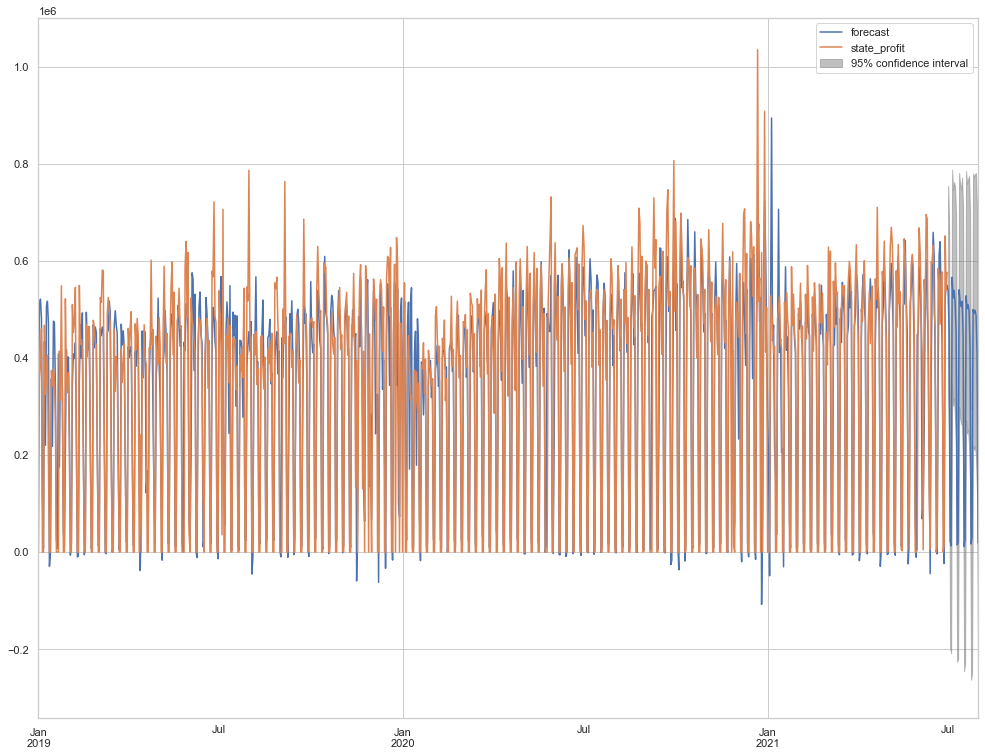

In [100]:
model_fit.plot_predict(start = 2555 , end = 3497);

In [101]:
y_pred = model_fit.forecast(steps = 31)[0]

In [102]:
save_scores(model_fit, 'daily_agg', 'Auto_regressive', 'p = 22')

In [103]:
results

,data_agg,model,params,rmse,mae
0,daily_agg,Auto_regressive,p = 1,266812.03,253416.67
1,daily_agg,Auto_regressive,p = 22,83677.87,58710.28


## Moving Average (MA) Model

The Moving Average model does not use the past forecasts to predict the future values whereas it uses the errors from the past forecasts.

Parameters of the model:

Number of MA (Moving Average) terms (q): q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

In [104]:
mod = ARMA(df_daily, order=(0,1))
model_fit = mod.fit()

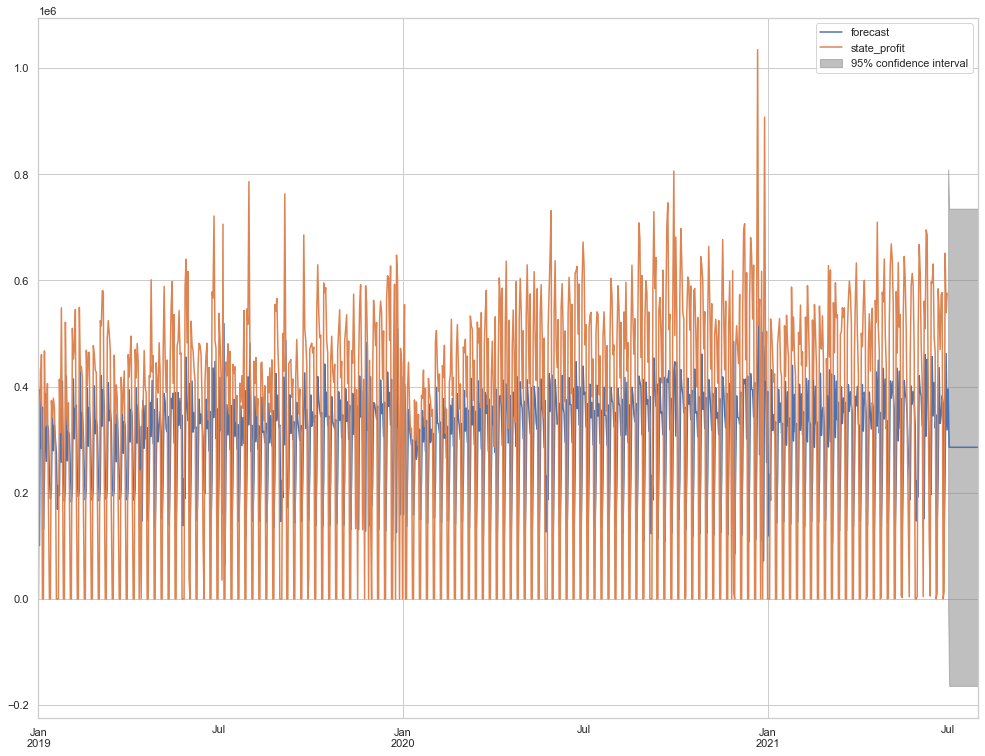

In [105]:
model_fit.plot_predict(start = 2555 , end = 3497);

In [106]:
y_pred = model_fit.forecast(steps = 31)[0]

In [107]:
save_scores(model_fit, 'daily_agg', 'Moving Avg', 'q =1')

### Autoregressive Moving Average ARMA(p,q) Model
Model forecasts next step in the sequence by joinning AR and MA.

Parameter of the model: The (p,q) order of the model for the number of AR parameters, and MA parameters to use.

We will choose 8 for p and a range of 1 to 7 for q

In [108]:
qs = np.zeros(11)

for q in (1,2,3,4,5,6,7,8,9,10):
    mod = ARMA(df_daily, order=(8,q))
    model_fit = mod.fit()
    qs[q] = model_fit.bic
    y_pred = model_fit.forecast(steps = 31)[0]
    save_scores(model_fit, 'daily_agg', 'ARMA', 'p=8, q={}'.format(q))
    


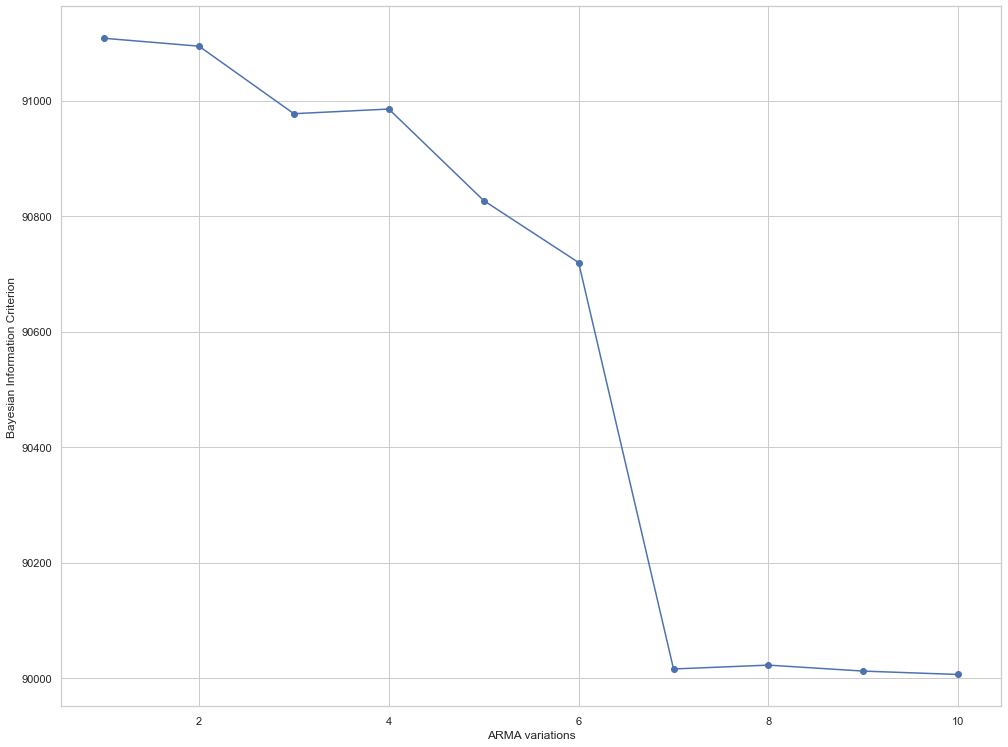

In [109]:
plt.plot(range(1,11), qs[1:11], marker='o')
plt.xlabel('ARMA variations')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [110]:
results

,data_agg,model,params,rmse,mae
0,daily_agg,Auto_regressive,p = 1,266812.03,253416.67
1,daily_agg,Auto_regressive,p = 22,83677.87,58710.28
2,daily_agg,Moving Avg,q =1,267337.41,254099.94
3,daily_agg,ARMA,"p=8, q=1",112019.81,85188.26
4,daily_agg,ARMA,"p=8, q=2",111626.59,82263.56
5,daily_agg,ARMA,"p=8, q=3",99546.12,80043.89
6,daily_agg,ARMA,"p=8, q=4",99600.75,80106.68
7,daily_agg,ARMA,"p=8, q=5",127233.67,100631.11
8,daily_agg,ARMA,"p=8, q=6",89376.30,70862.92
9,daily_agg,ARMA,"p=8, q=7",71607.31,59544.63


We can see that so far the ARMA(8,9) produced the lowest RMSE. We will use this as base model for our next iterations of ARIMA, SARIMA, SARIMAX.

In [111]:
mod = ARMA(df_daily, order=(8,9))
model_fit = mod.fit()

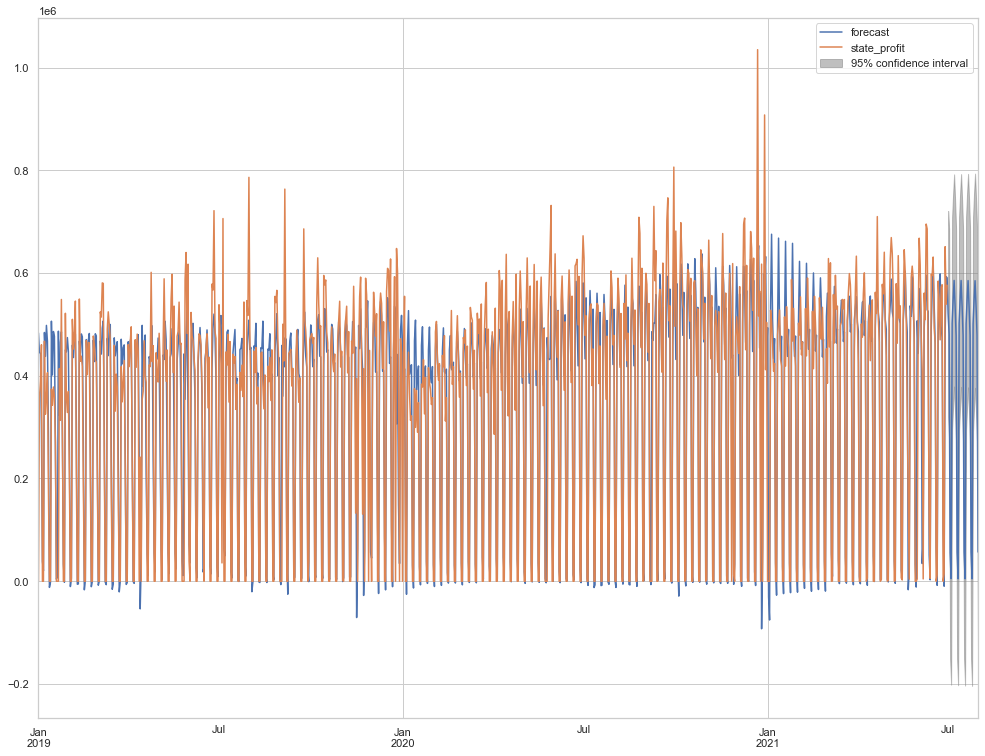

In [112]:
model_fit.plot_predict(start = 2555 , end = 3497);

### Autoregressive Integrated Moving Average (ARIMA)

ARIMA doesn't support seasonal time series. It supports them when seasonality component using methods such as seasonal differencing, is removed.
Non-seasonal parameters of model are labeled p,d,and q:

Number of AR (Auto-Regressive) terms (p) is number of lags of dependent variable (past values).

Number of Differences (d) is associated with the integrated part of the model, which effects the amount of differencing to apply to a time series. Non stationarity series which has trend and seasonality requires positive level of differencing (d>0).

Number of MA (Moving Average) terms (q)is size of the moving average part window of the model . After stationrizing the time series of daily usage, p and q are selected based on ACF and PACF respectively.

We will use our ARMA(8,9) as a base model with 0, 1 and 2 differencing.

In [121]:
for d in (0,1,2):
    mod = ARIMA(df_daily, order=(8,d,9))
    model_fit = mod.fit()
    y_pred = model_fit.forecast(steps = 31)[0]
    save_scores(model_fit, 'daily_agg', 'ARIMA', 'p=8, d={}, q=9'.format(d))


In [114]:
results.sort_values('rmse')

,data_agg,model,params,rmse,mae
11,daily_agg,ARMA,"p=8, q=9",70381.38,57362.76
13,daily_agg,ARIMA,"p=8, d=0, q=9",70381.38,57362.76
12,daily_agg,ARMA,"p=8, q=10",70393.36,58973.98
10,daily_agg,ARMA,"p=8, q=8",70928.67,58771.67
9,daily_agg,ARMA,"p=8, q=7",71607.31,59544.63
14,daily_agg,ARIMA,"p=8, d=1, q=9",71875.35,62193.71
1,daily_agg,Auto_regressive,p = 22,83677.87,58710.28
15,daily_agg,ARIMA,"p=8, d=2, q=9",88956.68,80302.91
8,daily_agg,ARMA,"p=8, q=6",89376.30,70862.92
5,daily_agg,ARMA,"p=8, q=3",99546.12,80043.89


In [115]:
for p in (0,1,2,3):
    for d in (0,1,2):
        for q in (0,1,2,3):
            try:
                mod = ARIMA(df_daily, order=(p, d, q))
                model_fit = mod.fit()
                y_pred = model_fit.forecast(steps = 31)[0]
                save_scores(model_fit, 'daily_agg', 'ARIMA', 'p={}, d={}, q={}'.format(p,d,q))
            except:
                continue


## Seasonal Autoregressive Integrated Moving Average (SARIMAX)

This is similar to ARIMA, but we introduce s, the seasonality

For our daily data the seasonality is 7, because of the weekly seasonality of our records.

In [129]:
mod = SARIMAX(df_daily, order=(1, 0, 1),seasonal_order=(1,1,0,7), simple_differencing=False,enforce_stationarity=False)
model_fit = mod.fit()
y_pred = model_fit.forecast(steps = 31)

save_scores(model_fit, 'daily_agg', 'SARIMAX', 'p=1, d=0, q=1, seasonal_order=(1,1,0,7)')

In [131]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       state_profit   No. Observations:                 3467
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 7)   Log Likelihood              -45245.241
Date:                            Fri, 13 Aug 2021   AIC                          90498.483
Time:                                    19:20:36   BIC                          90523.070
Sample:                                01-03-2012   HQIC                         90507.264
                                     - 06-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2868      0.085      3.389      0.001       0.121       0.453
ma.L1         -0.0746      0.089     -0.842      0.400      -0.248       0.099
ar.S.L7       -0.4251      0.010    -43.323      0.000      -0.444      -0.406
sigma2      1.699e+10   4.08e-12   4.17e+21      0.000     1.7e+10     1.7e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             20708.18
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.17e+36. Standard errors may be unstable.
"""

In [134]:
ps = (1,2,6)
ds = (0,1)
qs = (8,9,10)

for p in ps:
    for d in ds:
        for q in qs:
            mod = SARIMAX(df_daily, order=(p, d, q),seasonal_order=(1,1,0,7))
            model_fit = mod.fit()
            y_pred = model_fit.forecast(steps = 31)
            save_scores(model_fit, 'daily_agg', 'SARIMAX', 'p={}, d={}, q={}, seasonal_order=(1,1,0,7)'.format(p,d,q))

## Modeling monthly aggregated data

Now let's use this model with our monthly data

In [135]:
df_m = df[['state_profit']].resample('m').sum()

df_m.reset_index(inplace=True)
df_m['Date'] = pd.to_datetime(df_m['Date'])
df_m = df_m.set_index('Date')

df_m

,state_profit
Date,
2012-01-31,5320216.31
2012-02-29,6079004.91
2012-03-31,6064927.47
2012-04-30,6710304.28
2012-05-31,7442166.62
...,...
2021-02-28,9879334.94
2021-03-31,12271348.59
2021-04-30,11572070.73


Let's see our validation value

In [136]:
y_true_month = y_true.sum()
y_true_month

state_profit    11724830.36
dtype: float64

In [145]:
y_true = y_true_month

### AR model

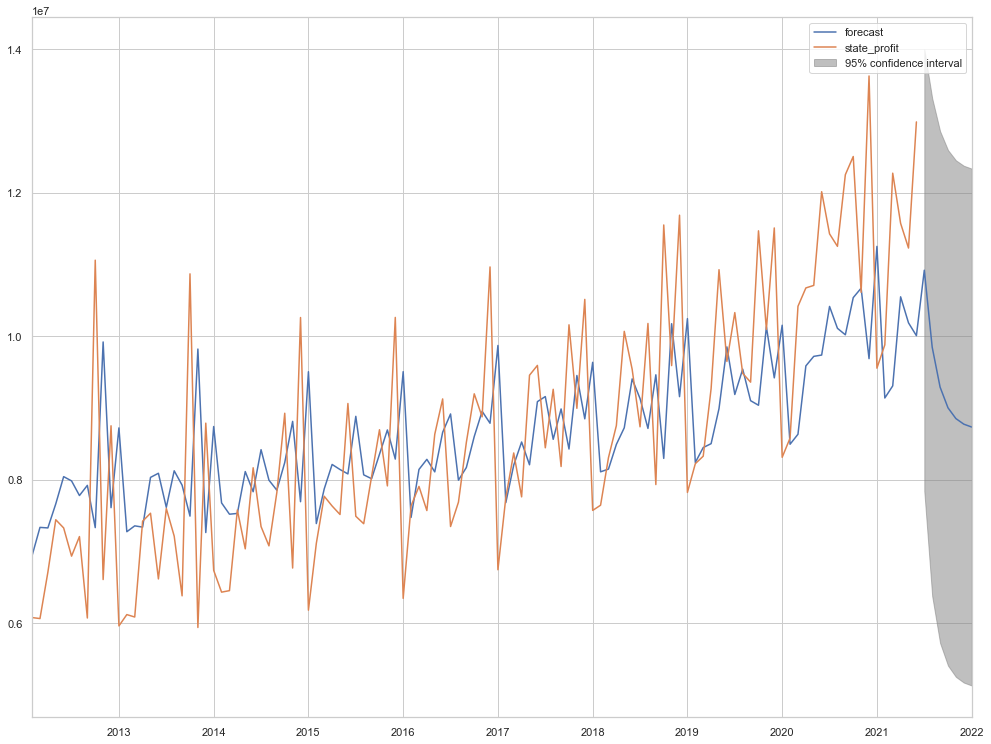

In [142]:
model = ARMA(df_m, order = (1,0))
result = model.fit()

result.plot_predict(start = 1, end = 120);

In [146]:
y_pred = result.forecast(steps = 1)[0]
save_scores(model_fit, 'month_agg', 'AR', 'p =1')

In [147]:
results

,data_agg,model,params,rmse,mae
0,daily_agg,Auto_regressive,p = 1,266812.03,253416.67
1,daily_agg,Auto_regressive,p = 22,83677.87,58710.28
2,daily_agg,Moving Avg,q =1,267337.41,254099.94
3,daily_agg,ARMA,"p=8, q=1",112019.81,85188.26
4,daily_agg,ARMA,"p=8, q=2",111626.59,82263.56
...,...,...,...,...,...
72,daily_agg,SARIMAX,"p=6, d=1, q=8, seasonal_order=(1,1,0,7)",76787.22,65916.96
73,daily_agg,SARIMAX,"p=6, d=1, q=9, seasonal_order=(1,1,0,7)",75846.30,67265.50
74,daily_agg,SARIMAX,"p=6, d=1, q=10, seasonal_order=(1,1,0,7)",73694.93,65132.80
75,month_agg,Moving Avg,q =1,8476033.22,8461513.96


### AR with Information Criteria

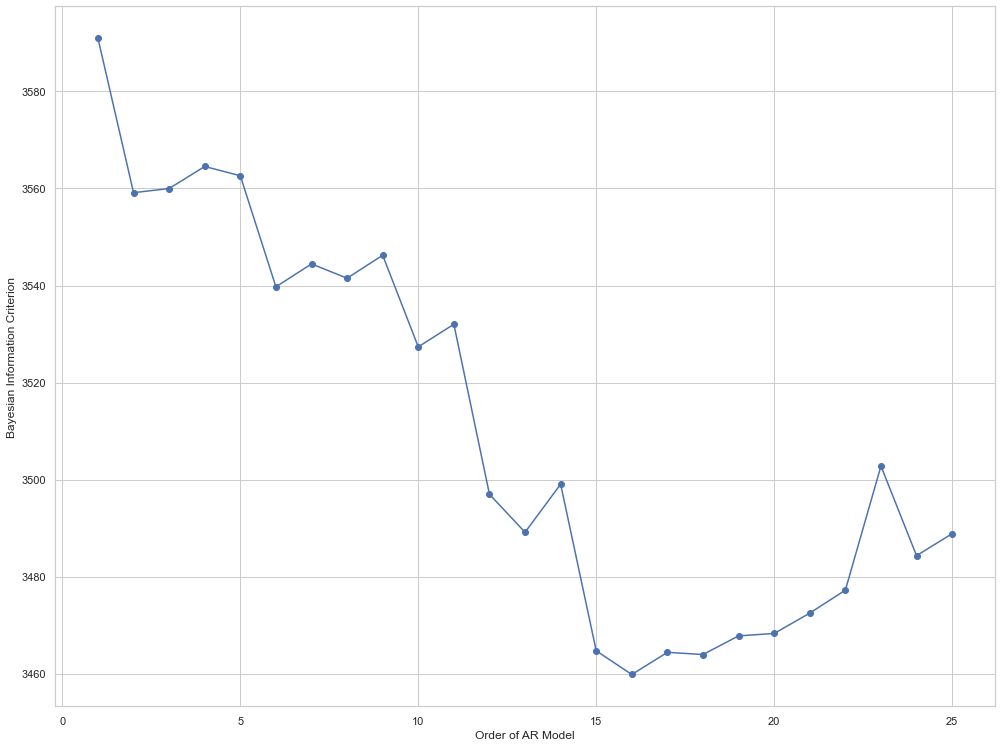

In [148]:
BIC = np.zeros(26)
for p in range(26):
    mod = ARMA(df_m, order=(p,0))
    model_fit = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = model_fit.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,26), BIC[1:26], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

The best order for our AR model is 16.

### AR16

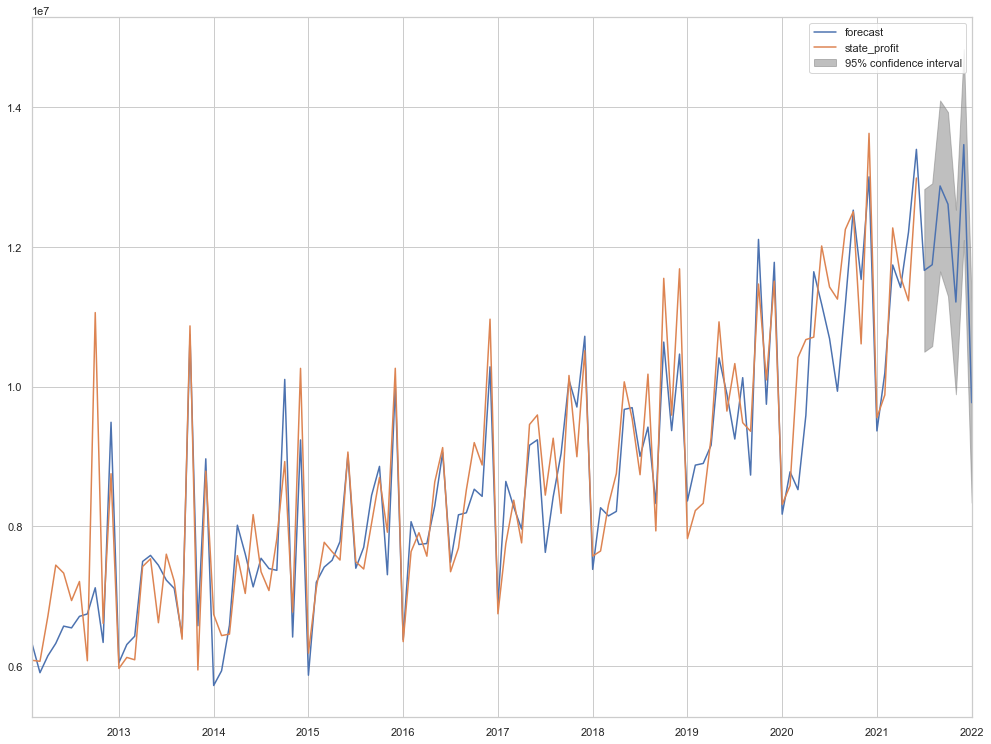

In [150]:
model = ARMA(df_m, order = (16,0))
result = model.fit()
y_pred = result.forecast(steps = 1)[0]
save_scores(model_fit, 'month_agg', 'AR', 'p =16')

result.plot_predict(start = 1, end = 120);

### MA model

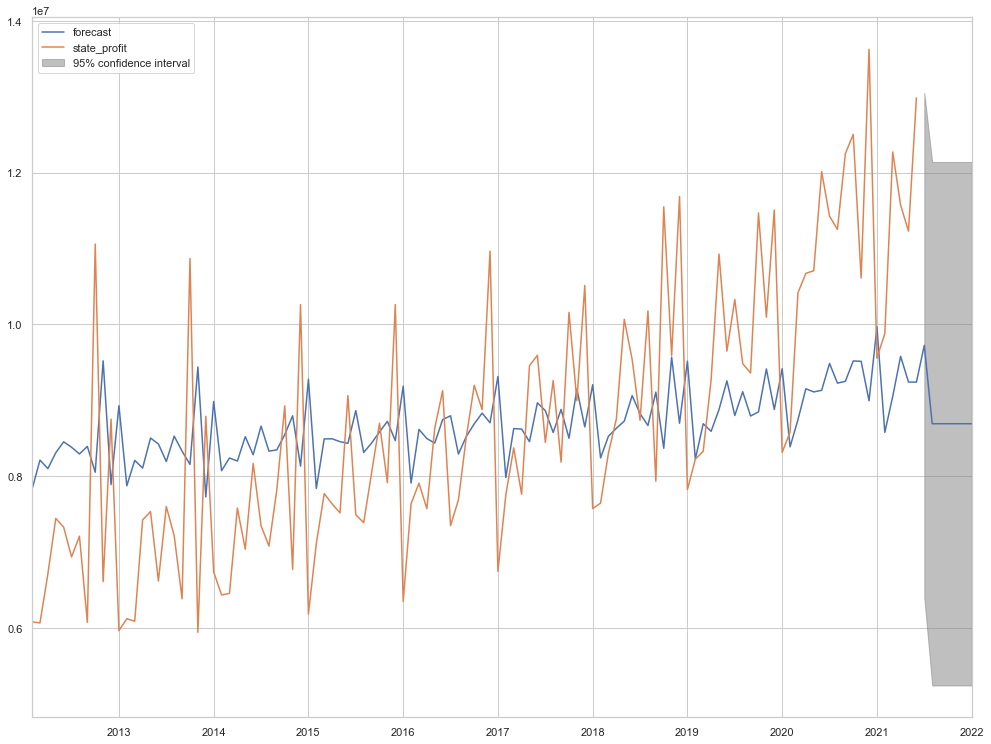

In [151]:
model = ARMA(df_m, order = (0,1))
result = model.fit()
y_pred = result.forecast(steps = 1)[0]
save_scores(model_fit, 'month_agg', 'Moving Average', 'q = 1')

result.plot_predict(start = 1, end = 120);

### ARMA

In [162]:

model = ARMA(df_m, order = (1,1))
model_fit = model.fit()
y_pred = model_fit.forecast(steps = 1)[0]
save_scores(model_fit, 'month_agg', 'ARMA', 'p=1, q=1')

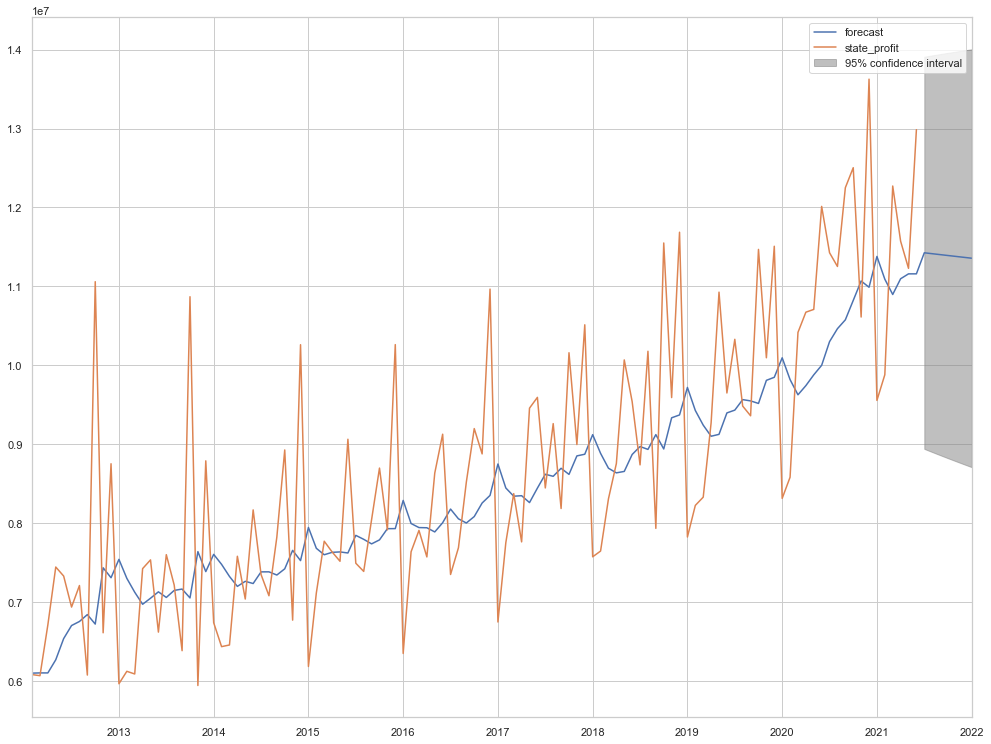

In [164]:
model_fit.plot_predict(start = 1, end = 120);

In [158]:
# qs = (2,4,7,10,13)

# for q in qs:
#     model = ARMA(df_m, order = (16,q))
#     model_fit = model.fit()
#     y_pred = model.forecast(steps = 1)[0]
#     save_scores(model_fit, 'month_agg', 'ARMA', 'p=16, q={}'.format(q))


Trying to run our ARMA model on a non-stationary data resulted in a ValueError:
The computed initial AR coefficients are not stationary. You should induce stationarity, choose a different model order, or you can pass your own start_params.

### ARIMA

In [179]:
mod = ARIMA(df_m, order=(12,1,1))
model_fit = mod.fit()
y_pred = model_fit.forecast(steps = 1)[0]
save_scores(model_fit, 'month_agg', 'ARIMA', 'p=1, d=1, q=1')

In [181]:
results.sort_values('rmse')

,data_agg,model,params,rmse,mae
112,month_agg,ARIMA,"p=0, d=2, q=2",52372.53,52372.53
88,month_agg,ARIMA,"p=0, d=2, q=2",52372.53,52372.53
77,month_agg,AR,p =16,61794.20,61794.20
59,daily_agg,SARIMAX,"p=1, d=0, q=10, seasonal_order=(1,1,0,7)",69173.20,56291.66
64,daily_agg,SARIMAX,"p=2, d=0, q=9, seasonal_order=(1,1,0,7)",69176.27,55936.69
...,...,...,...,...,...
96,month_agg,ARIMA,"p=0, d=0, q=0",3034520.62,3034520.62
80,month_agg,ARIMA,"p=0, d=0, q=0",3034520.62,3034520.62
108,month_agg,ARIMA,"p=0, d=0, q=2",3119628.33,3119628.33
82,month_agg,ARIMA,"p=0, d=0, q=2",3119628.33,3119628.33


In [167]:

# mod = ARIMA(df_m, order=(16,1,1))
# model_fit = mod.fit()
# y_pred = model_fit.forecast(steps = 1)[0]
# save_scores(model_fit, 'month_agg', 'ARIMA', 'p=16, d=1, q=1')


Trying to run our ARMA model on a non-stationary data resulted in the same ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

### SARIMAX

For our monthly aggregated data we will use 12 for seasonal_order.

In [182]:
ps = (1,2,6)
ds = (0,1)
qs = (8,9,10)

for p in ps:
    for d in ds:
        for q in qs:
            mod = SARIMAX(df_m, order=(p, d, q),seasonal_order=(1,1,0,12))
            model_fit = mod.fit()
            y_pred = model_fit.forecast(steps = 1)
            save_scores(model_fit, 'month_agg', 'SARIMAX', 'p={}, d={}, q={}, seasonal_order=(1,1,0,12)'.format(p,d,q))

### Choosing the best model

Let's look at the top 20 models

In [187]:
results.sort_values('rmse').head(20)

,data_agg,model,params,rmse,mae
139,month_agg,SARIMAX,"p=2, d=1, q=10, seasonal_order=(1,1,0,12)",3330.86,3330.86
136,month_agg,SARIMAX,"p=2, d=0, q=10, seasonal_order=(1,1,0,12)",42648.82,42648.82
88,month_agg,ARIMA,"p=0, d=2, q=2",52372.53,52372.53
112,month_agg,ARIMA,"p=0, d=2, q=2",52372.53,52372.53
77,month_agg,AR,p =16,61794.20,61794.20
128,month_agg,SARIMAX,"p=1, d=0, q=8, seasonal_order=(1,1,0,12)",61840.06,61840.06
59,daily_agg,SARIMAX,"p=1, d=0, q=10, seasonal_order=(1,1,0,7)",69173.20,56291.66
64,daily_agg,SARIMAX,"p=2, d=0, q=9, seasonal_order=(1,1,0,7)",69176.27,55936.69
65,daily_agg,SARIMAX,"p=2, d=0, q=10, seasonal_order=(1,1,0,7)",69359.03,56583.06
57,daily_agg,SARIMAX,"p=1, d=0, q=8, seasonal_order=(1,1,0,7)",69399.36,55900.98


We can see that the best results came when using the **SARIMAX with p=2, d=1, q=10, seasonal_order=(1,1,0,12) on monthly aggregations** by a huge margin.

Let's see how big is the margin of error compared to the real value from July 2021

In [188]:
y_true


state_profit    11724830.36
dtype: float64

In [196]:
results['Accuracy on Validation'] = (((11724830.36 - results.rmse) / 11724830.36)*100)
results

,data_agg,model,params,rmse,mae,Accuracy on Validation
0,daily_agg,Auto_regressive,p = 1,266812.03,253416.67,97.724385
1,daily_agg,Auto_regressive,p = 22,83677.87,58710.28,99.286319
2,daily_agg,Moving Avg,q =1,267337.41,254099.94,97.719904
3,daily_agg,ARMA,"p=8, q=1",112019.81,85188.26,99.044593
4,daily_agg,ARMA,"p=8, q=2",111626.59,82263.56,99.047947
...,...,...,...,...,...,...
141,month_agg,SARIMAX,"p=6, d=0, q=9, seasonal_order=(1,1,0,12)",250614.03,250614.03,97.862536
142,month_agg,SARIMAX,"p=6, d=0, q=10, seasonal_order=(1,1,0,12)",564291.28,564291.28,95.187212
143,month_agg,SARIMAX,"p=6, d=1, q=8, seasonal_order=(1,1,0,12)",213521.66,213521.66,98.178893
144,month_agg,SARIMAX,"p=6, d=1, q=9, seasonal_order=(1,1,0,12)",211574.28,211574.28,98.195502


In [197]:
results.sort_values('rmse').head(20)

,data_agg,model,params,rmse,mae,Accuracy on Validation
139,month_agg,SARIMAX,"p=2, d=1, q=10, seasonal_order=(1,1,0,12)",3330.86,3330.86,99.971591
136,month_agg,SARIMAX,"p=2, d=0, q=10, seasonal_order=(1,1,0,12)",42648.82,42648.82,99.636252
88,month_agg,ARIMA,"p=0, d=2, q=2",52372.53,52372.53,99.553320
112,month_agg,ARIMA,"p=0, d=2, q=2",52372.53,52372.53,99.553320
77,month_agg,AR,p =16,61794.20,61794.20,99.472963
128,month_agg,SARIMAX,"p=1, d=0, q=8, seasonal_order=(1,1,0,12)",61840.06,61840.06,99.472572
59,daily_agg,SARIMAX,"p=1, d=0, q=10, seasonal_order=(1,1,0,7)",69173.20,56291.66,99.410028
64,daily_agg,SARIMAX,"p=2, d=0, q=9, seasonal_order=(1,1,0,7)",69176.27,55936.69,99.410002
65,daily_agg,SARIMAX,"p=2, d=0, q=10, seasonal_order=(1,1,0,7)",69359.03,56583.06,99.408443
57,daily_agg,SARIMAX,"p=1, d=0, q=8, seasonal_order=(1,1,0,7)",69399.36,55900.98,99.408099


In [203]:
best_model = SARIMAX(df_m, order=(p, d, q),seasonal_order=(1,1,0,12))
best_model = best_model.fit()

In [204]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         state_profit   No. Observations:                  114
Model:             SARIMAX(6, 1, 10)x(1, 1, [], 12)   Log Likelihood               -1503.757
Date:                              Fri, 13 Aug 2021   AIC                           3043.515
Time:                                      22:43:59   BIC                           3090.587
Sample:                                  01-31-2012   HQIC                          3062.571
                                       - 06-30-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8295      0.154     -5.392      0.000      -1.131      -0.528
ar.L2         -0.5669      0.182     -3.119      0.002      -0.923      -0.211
ar.L3          0.1987      0.146      1.364      0.173      -0.087       0.484
ar.L4          0.6568      0.160      4.115      0.000       0.344       0.970
ar.L5          0.7096      0.157      4.528      0.000       0.402       1.017
ar.L6          0.8030      0.109      7.347      0.000       0.589       1.017
ma.L1          0.4657      0.369      1.264      0.206      -0.257       1.188
ma.L2          0.3942      0.421      0.936      0.349      -0.432       1.220
ma.L3         -0.2402      0.352     -0.682      0.496      -0.931       0.450
ma.L4         -0.6491      0.396     -1.640      0.101      -1.425       0.127
ma.L5         -0.5572      0.238     -2.343      0.019      -1.023      -0.091
ma.L6         -0.6685      0.143     -4.665      0.000      -0.949      -0.388
ma.L7          0.2718      0.080      3.400      0.001       0.115       0.428
ma.L8         -0.1314      0.088     -1.501      0.133      -0.303       0.040
ma.L9          0.0417      0.096      0.435      0.664      -0.146       0.230
ma.L10         0.0739      0.074      0.998      0.318      -0.071       0.219
ar.S.L12      -0.1523      0.047     -3.207      0.001      -0.245      -0.059
sigma2      3.361e+11   7.99e-12   4.21e+22      0.000    3.36e+11    3.36e+11
===================================================================================
Ljung-Box (L1) (Q):                  12.59   Jarque-Bera (JB):                 3.32
Prob(Q):                              0.00   Prob(JB):                         0.19
Heteroskedasticity (H):               0.78   Skew:                            -0.43
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.59e+37. Standard errors may be unstable.
"""

In [209]:
prediction = best_model.forecast(steps = 6)
prediction

2021-07-31    1.147184e+07
2021-08-31    1.157813e+07
2021-09-30    1.299555e+07
2021-10-31    1.261618e+07
2021-11-30    1.138980e+07
2021-12-31    1.440307e+07
Freq: M, Name: predicted_mean, dtype: float64

In [212]:
past_pred = best_model.predict()
past_pred

2012-01-31    0.000000e+00
2012-02-29    2.845758e+06
2012-03-31    3.209794e+06
2012-04-30    7.734524e+06
2012-05-31    6.412751e+06
                  ...     
2021-02-28    9.892192e+06
2021-03-31    1.229827e+07
2021-04-30    1.166894e+07
2021-05-31    1.209509e+07
2021-06-30    1.325608e+07
Freq: M, Name: predicted_mean, Length: 114, dtype: float64

In [213]:
prediction_total = past_pred.append(prediction)
prediction_total

2012-01-31    0.000000e+00
2012-02-29    2.845758e+06
2012-03-31    3.209794e+06
2012-04-30    7.734524e+06
2012-05-31    6.412751e+06
                  ...     
2021-08-31    1.157813e+07
2021-09-30    1.299555e+07
2021-10-31    1.261618e+07
2021-11-30    1.138980e+07
2021-12-31    1.440307e+07
Freq: M, Name: predicted_mean, Length: 120, dtype: float64

<AxesSubplot:xlabel='Date'>

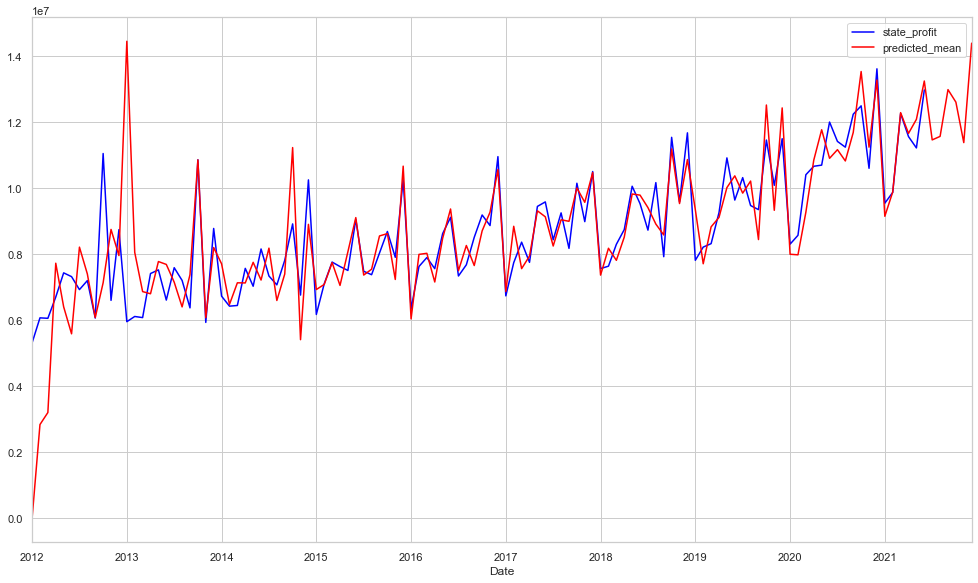

In [217]:
df_m.plot(figsize=(15,9), legend=True, color='blue')
prediction_total.plot(legend=True, color='red', figsize=(15,9))


To conclude, our best models have an accuracy of over 99% when predicting Profits for the month of July, which is very high.

### Saving the model and aggregated data

In [219]:
import pickle

filename = '../models/best_model.sav'
pickle.dump(best_model, open(filename, 'wb'))


In [220]:
# Saving data to final folder
df_m.to_csv('../data/final/monthly_data.csv')
df_daily.to_csv('../data/final/daily_data.csv')